Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

1. 시나리오1: Frontal elevation of arms -> Knees bending
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 2.324
 >>> Standard Deviation: 1.910
----------------------------------------------------------------------------------------------------
[Scenario] Frontal elevation of arms -> Knees bending | subject1 | Frontal elevation of arms(20) -> Knees bending(20) | GT_total=40 | Pred(win)=50.86 | Diff=+10.86 | MAE=10.86 | k_hat(full)=1.04 | ent(full)=0.076 | boundary=3072
[Scenario] Frontal elevation of arms -> Knees bending | subject2 | Frontal elevation of arms(20) -> Knees bending(21) | GT_total=41 | Pred(win)=53.70 | Diff=+12.70 | MAE=12.70 | k_hat(full)=1.02 | ent(full)=0.054 | boundary

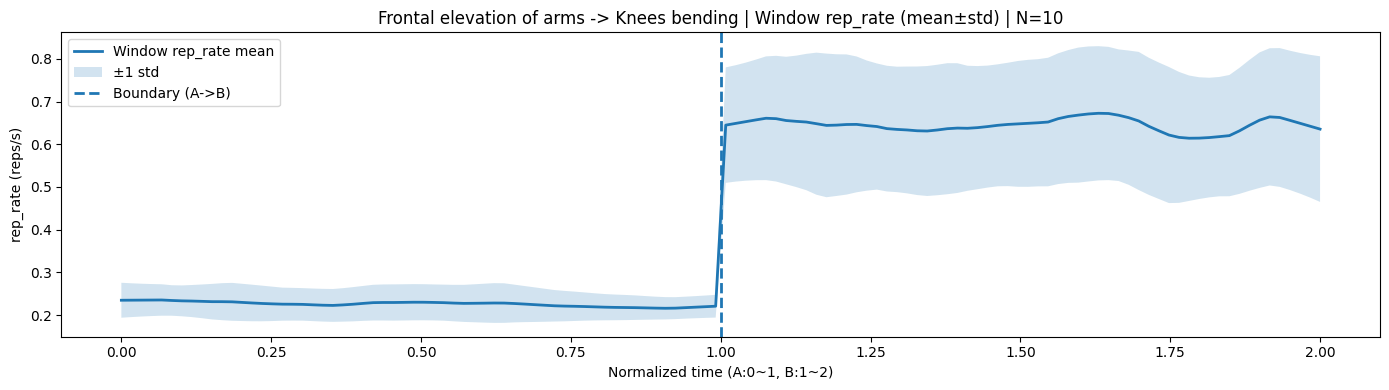

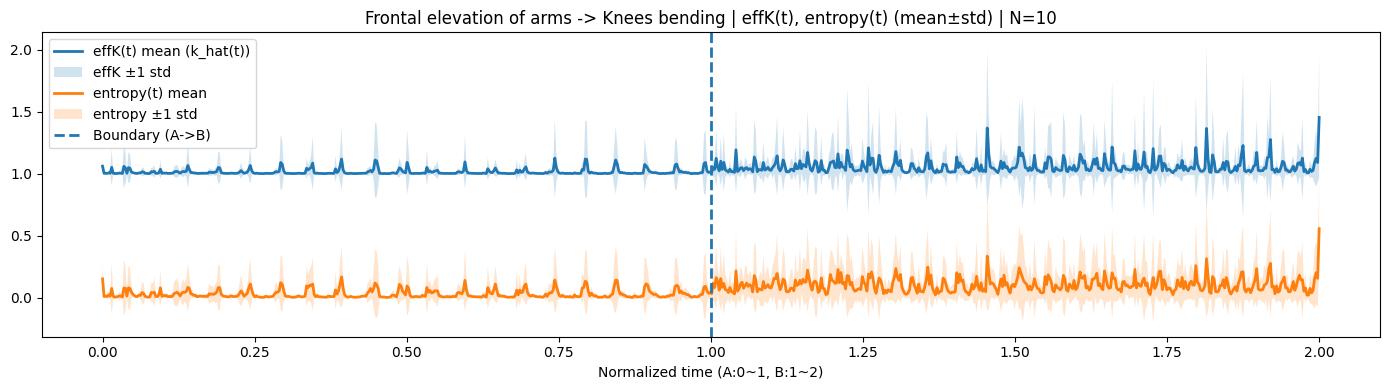

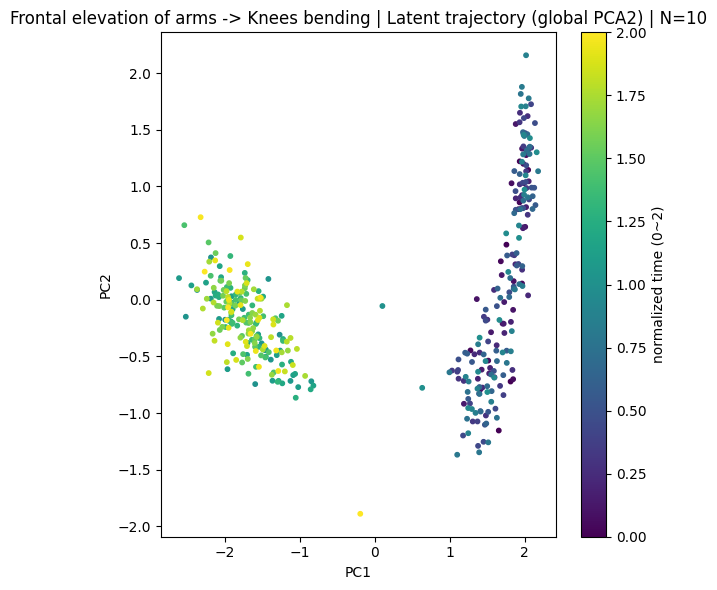


1. 시나리오2: Knees bending -> Frontal elevation of arms
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 4.274
 >>> Standard Deviation: 3.012
----------------------------------------------------------------------------------------------------
[Scenario] Knees bending -> Frontal elevation of arms | subject1 | Knees bending(20) -> Frontal elevation of arms(20) | GT_total=40 | Pred(win)=66.34 | Diff=+26.34 | MAE=26.34 | k_hat(full)=1.02 | ent(full)=0.059 | boundary=3379
[Scenario] Knees bending -> Frontal elevation of arms | subject2 | Knees bending(21) -> Frontal elevation of arms(20) | GT_total=41 | Pred(win)=42.73 | Diff=+1.73 | MAE=1.73 | k_hat(full)=1.01 | ent(full)=0.041 | boundary=3430
[Scenario] Knees bending -> Frontal elevation of arms | subject3 | Knees bending(21) -> Frontal elev

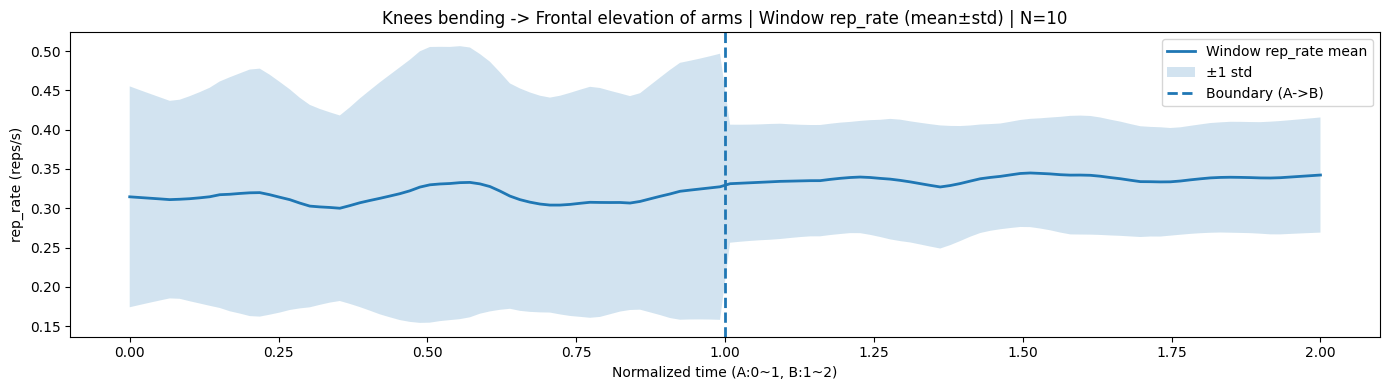

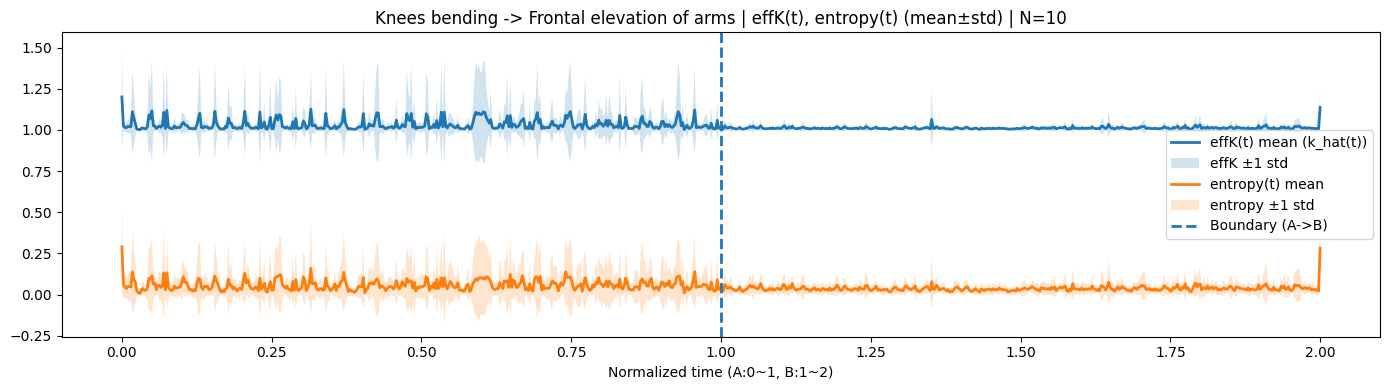

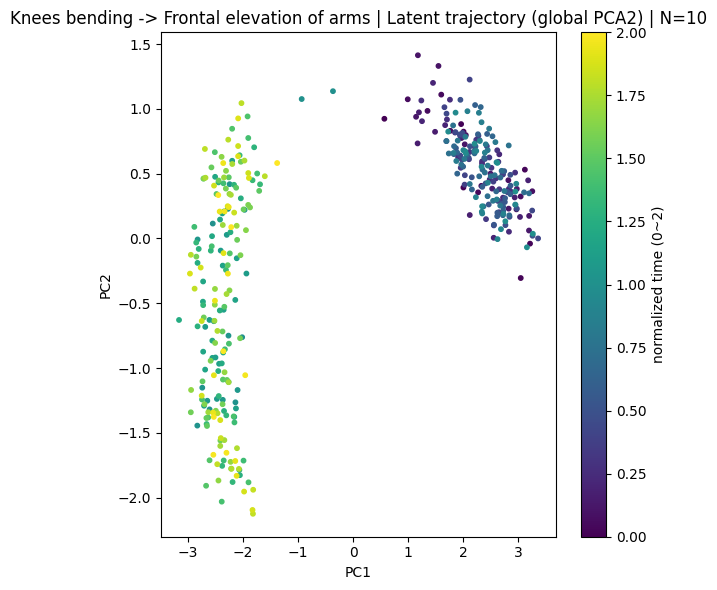


1. 시나리오3: Waist bends forward -> Jump front & back
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 5.261
 >>> Standard Deviation: 3.006
----------------------------------------------------------------------------------------------------
[Scenario] Waist bends forward -> Jump front & back | subject1 | Waist bends forward(21) -> Jump front & back(20) | GT_total=41 | Pred(win)=26.26 | Diff=-14.74 | MAE=14.74 | k_hat(full)=1.10 | ent(full)=0.214 | boundary=3072
[Scenario] Waist bends forward -> Jump front & back | subject2 | Waist bends forward(19) -> Jump front & back(22) | GT_total=41 | Pred(win)=31.27 | Diff=-9.73 | MAE=9.73 | k_hat(full)=1.07 | ent(full)=0.155 | boundary=3174
[Scenario] Waist bends forward -> Jump front & back | subject3 | Waist bends forward(21) -> Jump front & back(

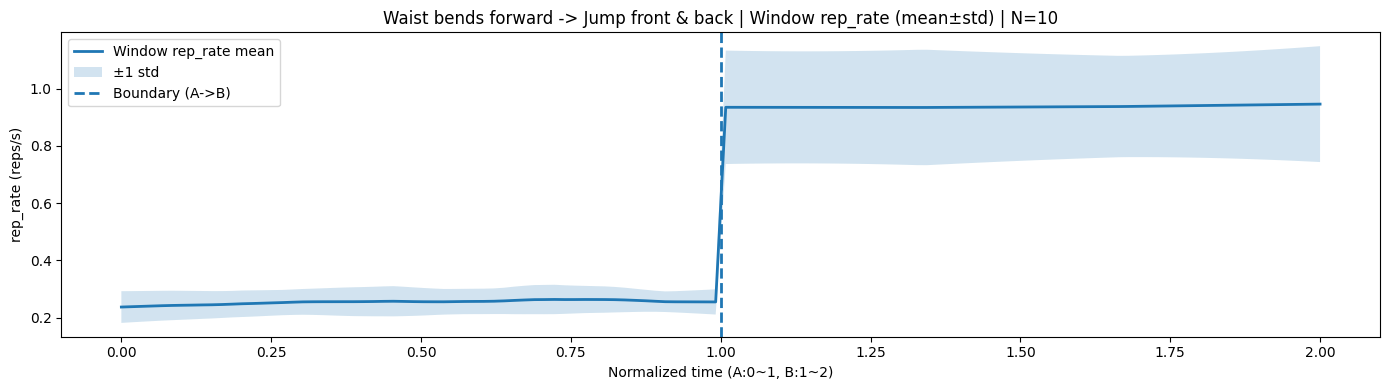

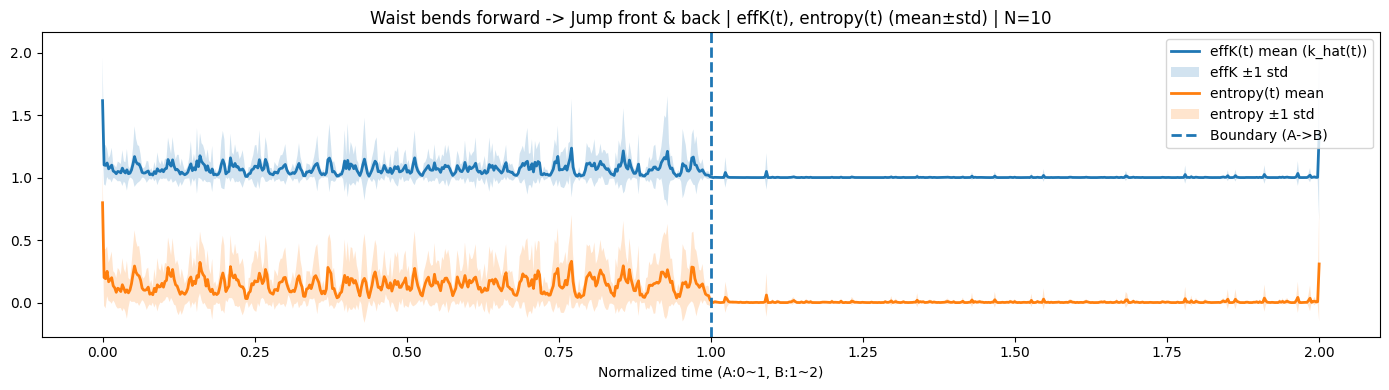

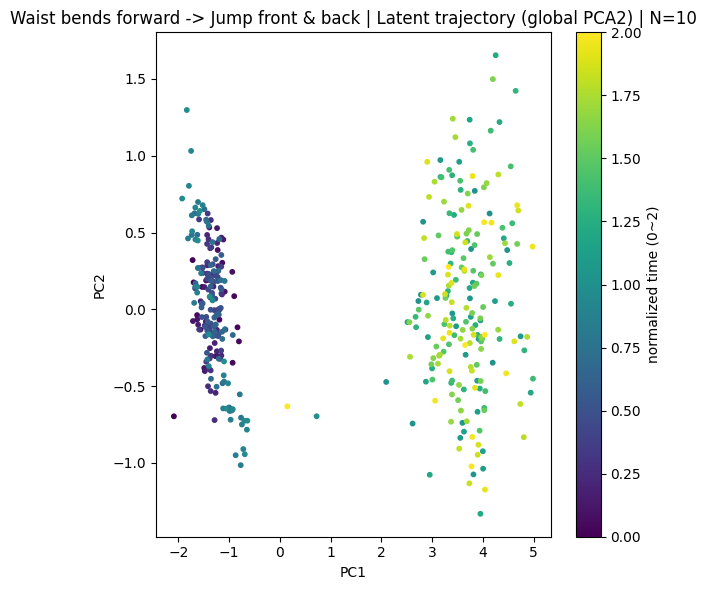


1. 시나리오4: Jump front & back -> Waist bends forward
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 1.103
 >>> Standard Deviation: 1.083
----------------------------------------------------------------------------------------------------
[Scenario] Jump front & back -> Waist bends forward | subject1 | Jump front & back(20) -> Waist bends forward(21) | GT_total=41 | Pred(win)=66.05 | Diff=+25.05 | MAE=25.05 | k_hat(full)=3.32 | ent(full)=1.183 | boundary=1075
[Scenario] Jump front & back -> Waist bends forward | subject2 | Jump front & back(22) -> Waist bends forward(19) | GT_total=41 | Pred(win)=79.53 | Diff=+38.53 | MAE=38.53 | k_hat(full)=2.18 | ent(full)=0.898 | boundary=1024
[Scenario] Jump front & back -> Waist bends forward | subject3 | Jump front & back(21) -> Waist bends forwar

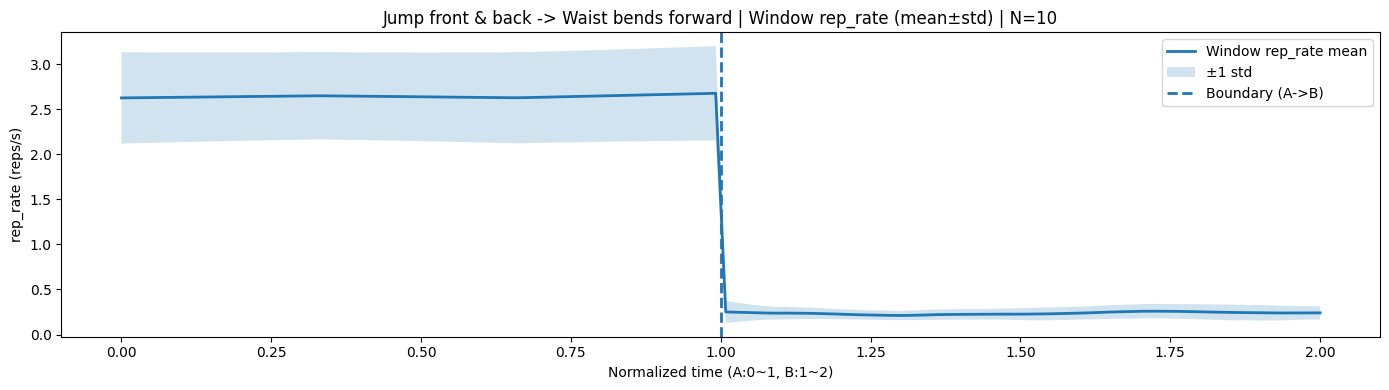

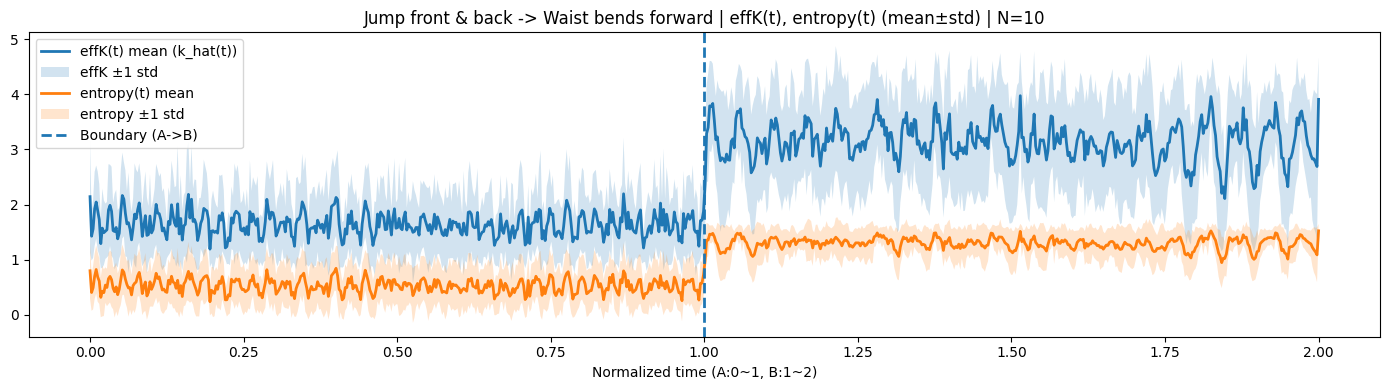

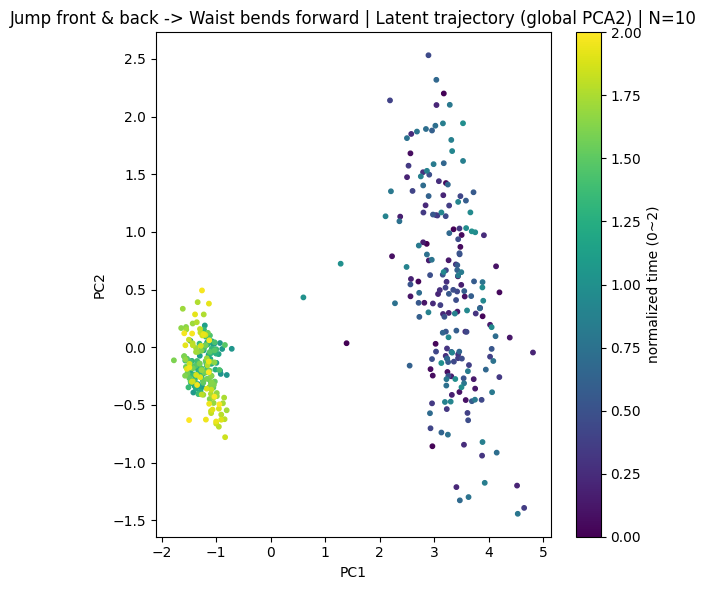

In [3]:
# =========================
# Count-only K-auto (Multi-event) + Windowing version
#
# ✅ Windowing added:
# - TRAIN: trial -> sliding windows (window-level count = trial-average rate * window duration)
# - TEST : trial 그대로 두고, windowing inference로 window rate 평균 -> 전체 count 예측
# - k_hat / entropy / rep_rate / phase heatmap은 (표현학습 확인용) full-trial 1회 forward로 기록
#
# ✅ (ADDED) Extension Scenario (TEST only):
# - raw signal concat A-B (single trials)
# - boundary index 저장 (meta)
# - GT_total = GT[A][subj] + GT[B][subj] (user-provided dict)
# - scenarios:
#   1) Knees bending -> Frontal elevation of arms
#   2) Waist bends forward -> Jump front & back
#
# - Scenario1(KB->FEA): TRAIN act = Knees bending (8)
# - Scenario2(WBF->JFB): TRAIN act = Waist bends forward (6)
# - GT_BY_ACT 기반이라 ALL_LABELS 없이 label_config 생성
# - raw concat 후 mixed 전체로 1회 z-score 정규화
# - 로그 포맷: 시나리오별로 Train Summary -> subject별 Scenario 라인(+MAE) -> Scenario Summary
#
# ✅ (UPDATED) Visualization:
# - subject별 plot 저장 X (너무 많음)
# - 시나리오당 딱 3장만 저장:
#   1) Window-level rep_rate mean±std (+ boundary)
#   2) effK(t)=k_hat(t), entropy(t) mean±std (+ boundary)
#   3) Latent trajectory (global PCA2) mean trajectory (+ std circle markers) (+ boundary marker)
# =========================

import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns  # kept
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # kept

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score 정규화 (표준화) 평균=0, std=1
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,              # (T, C)
                'count': float(gt_count),      # trial total count
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ---------------------------------------------------------------------
# ✅ Mixed A-B builder (raw concat + boundary meta)
#     - A/B raw concat 후 mixed 전체로 1회 z-score
#     - (ADDED) data_A / data_B : mixed 기준 정규화된 A/B segment
# ---------------------------------------------------------------------
def get_single_trial_from_full_data(subj, act_id, gt_count, full_data, target_map, feature_map, normalize=True):
    act_name = target_map.get(act_id)
    feats = feature_map.get(act_id)

    if subj not in full_data or act_name not in full_data[subj]:
        return None

    raw_df = full_data[subj][act_name][feats]
    x = raw_df.values.astype(np.float32)

    if normalize:
        mean = x.mean(axis=0)
        std = x.std(axis=0) + 1e-6
        x = (x - mean) / std

    return {
        "data": x,
        "count": float(gt_count),
        "meta": f"{subj}_{act_name}"
    }


def build_mixed_ab_trial(subj, actA_id, actB_id, config, full_data):
    gt_map = config.get("GT_BY_ACT", {})
    if actA_id not in gt_map or actB_id not in gt_map:
        return None
    if subj not in gt_map[actA_id] or subj not in gt_map[actB_id]:
        return None

    gtA = float(gt_map[actA_id][subj])
    gtB = float(gt_map[actB_id][subj])
    gt_total = gtA + gtB

    A = get_single_trial_from_full_data(
        subj, actA_id, gtA, full_data,
        config["TARGET_ACTIVITIES_MAP"], config["ACT_FEATURE_MAP"],
        normalize=False
    )
    B = get_single_trial_from_full_data(
        subj, actB_id, gtB, full_data,
        config["TARGET_ACTIVITIES_MAP"], config["ACT_FEATURE_MAP"],
        normalize=False
    )
    if A is None or B is None:
        return None

    xA_raw = A["data"]
    xB_raw = B["data"]
    boundary = int(xA_raw.shape[0])

    x_mix_raw = np.concatenate([xA_raw, xB_raw], axis=0).astype(np.float32)

    mean = x_mix_raw.mean(axis=0)
    std = x_mix_raw.std(axis=0) + 1e-6
    x_mix = (x_mix_raw - mean) / std

    # ✅ for A/B split analysis
    xA = (xA_raw - mean) / std
    xB = (xB_raw - mean) / std

    actA_name = config["TARGET_ACTIVITIES_MAP"].get(actA_id, str(actA_id))
    actB_name = config["TARGET_ACTIVITIES_MAP"].get(actB_id, str(actB_id))

    return {
        "data": x_mix,
        "count": float(gt_total),
        "meta": f"{subj}__{actA_name}__TO__{actB_name}",
        "boundary": boundary,
        "meta_detail": {
            "subj": subj,
            "actA_id": actA_id, "actB_id": actB_id,
            "actA_name": actA_name, "actB_name": actB_name,
            "gtA": gtA, "gtB": gtB,
            "gt_total": gt_total,
        },
        "data_A": xA,
        "data_B": xB,
        "T_A": int(xA.shape[0]),
        "T_B": int(xB.shape[0]),
    }


# ---------------------------------------------------------------------
# 2.5) ✅ Windowing (added)
# ---------------------------------------------------------------------
def trial_list_to_windows(trial_list, fs, win_sec=8.0, stride_sec=4.0, drop_last=True):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    assert win_len > 0 and stride > 0

    windows = []
    for item in trial_list:
        x = item["data"]
        T = x.shape[0]
        total_count = float(item["count"])
        meta = item["meta"]

        total_dur = max(T / float(fs), 1e-6)
        rate_trial = total_count / total_dur

        if T < win_len:
            win_dur = T / float(fs)
            windows.append({
                "data": x,
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[0:{T}]",
                "parent_meta": meta,
                "parent_T": T,
                "win_start": 0,
                "win_end": T,
            })
            continue

        last_start = T - win_len
        starts = list(range(0, last_start + 1, stride))

        for st in starts:
            ed = st + win_len
            win_dur = win_len / float(fs)
            windows.append({
                "data": x[st:ed],
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[{st}:{ed}]",
                "parent_meta": meta,
                "parent_T": T,
                "win_start": st,
                "win_end": ed,
            })

        if not drop_last:
            last_st = starts[-1] + stride
            if last_st < T:
                ed = T
                win_dur = (ed - last_st) / float(fs)
                windows.append({
                    "data": x[last_st:ed],
                    "count": rate_trial * win_dur,
                    "meta": f"{meta}__win[{last_st}:{ed}]",
                    "parent_meta": meta,
                    "parent_T": T,
                    "win_start": last_st,
                    "win_end": ed,
                })

    return windows


def predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]
    total_dur = T / float(fs)

    if T <= win_len:
        x_tensor = torch.tensor(x_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
        with torch.no_grad():
            rate_hat, _, _, _ = model(x_tensor, mask=None, tau=tau)
        pred_count = float(rate_hat.item() * total_dur)
        return pred_count, np.array([float(rate_hat.item())], dtype=np.float32)

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)

    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())

    rates = np.concatenate(rates, axis=0)
    rate_mean = float(rates.mean())
    pred_count = rate_mean * total_dur
    return float(pred_count), rates


# ---------------------------------------------------------------------
# ✅ (ADDED) Helpers for scenario-avg plots
# ---------------------------------------------------------------------
def get_window_rate_curve(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]

    if T <= win_len:
        pred_count, rates = predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=tau, batch_size=batch_size)
        t_cent = np.array([0.5 * (T / float(fs))], dtype=np.float32)
        return t_cent, rates.astype(np.float32)

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)

    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())
    rates = np.concatenate(rates, axis=0).astype(np.float32)

    centers = np.array([(st + 0.5 * win_len) / float(fs) for st in starts], dtype=np.float32)
    return centers, rates


def resample_1d(y, new_len):
    y = np.asarray(y, dtype=np.float32)
    if y.size == 0:
        return np.zeros((new_len,), dtype=np.float32)
    if y.size == 1:
        return np.full((new_len,), float(y[0]), dtype=np.float32)
    x_old = np.linspace(0.0, 1.0, num=y.size, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=new_len, dtype=np.float32)
    return np.interp(x_new, x_old, y).astype(np.float32)


def resample_2d(Y, new_len):
    Y = np.asarray(Y, dtype=np.float32)
    if Y.shape[0] == 0:
        return np.zeros((new_len, Y.shape[1]), dtype=np.float32)
    if Y.shape[0] == 1:
        return np.repeat(Y, repeats=new_len, axis=0).astype(np.float32)
    x_old = np.linspace(0.0, 1.0, num=Y.shape[0], dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=new_len, dtype=np.float32)
    out = []
    for d in range(Y.shape[1]):
        out.append(np.interp(x_new, x_old, Y[:, d]))
    return np.stack(out, axis=1).astype(np.float32)


def compute_entropy_t(phase_p_tk, eps=1e-8):
    phase_p_tk = np.asarray(phase_p_tk, dtype=np.float32)
    return (-(phase_p_tk * np.log(phase_p_tk + eps)).sum(axis=1)).astype(np.float32)


def compute_effk_t(phase_p_tk, eps=1e-6):
    phase_p_tk = np.asarray(phase_p_tk, dtype=np.float32)
    denom = (phase_p_tk ** 2).sum(axis=1) + eps
    return (1.0 / denom).astype(np.float32)


def global_pca2(Z_all):
    """
    Z_all: (N,D)
    returns: mean (D,), V2 (2,D)  such that proj = (Z-mean) @ V2.T
    """
    Z_all = np.asarray(Z_all, dtype=np.float32)
    mu = Z_all.mean(axis=0, keepdims=True)
    Zc = Z_all - mu
    _, _, Vt = np.linalg.svd(Zc, full_matrices=False)
    V2 = Vt[:2].astype(np.float32)  # (2,D)
    return mu.squeeze(0).astype(np.float32), V2


def plot_scenario_mean_std(
    save_dir,
    scen_name,
    fs,
    win_t, win_mean, win_std,
    eff_t, eff_mean, eff_std,
    ent_mean, ent_std,
    lat_xy_mean, lat_xy_std,
    n_subjects,
):
    # (1) Window-level rep_rate mean±std
    plt.figure(figsize=(14, 4))
    plt.plot(win_t, win_mean, linewidth=2, label="Window rep_rate mean")
    plt.fill_between(win_t, win_mean - win_std, win_mean + win_std, alpha=0.2, label="±1 std")
    plt.axvline(1.0, linestyle="--", linewidth=2, label="Boundary (A->B)")
    plt.xlabel("Normalized time (A:0~1, B:1~2)")
    plt.ylabel("rep_rate (reps/s)")
    plt.title(f"{scen_name} | Window rep_rate (mean±std) | N={n_subjects}")
    plt.legend()
    plt.tight_layout()
    plt.show()          # ✅ show로 변경
    # plt.close()       # (원하면 메모리 아끼려고 추가)

    # (2) effK(t) & entropy(t) mean±std
    plt.figure(figsize=(14, 4))
    plt.plot(eff_t, eff_mean, linewidth=2, label="effK(t) mean (k_hat(t))")
    plt.fill_between(eff_t, eff_mean - eff_std, eff_mean + eff_std, alpha=0.2, label="effK ±1 std")
    plt.plot(eff_t, ent_mean, linewidth=2, label="entropy(t) mean")
    plt.fill_between(eff_t, ent_mean - ent_std, ent_mean + ent_std, alpha=0.2, label="entropy ±1 std")
    plt.axvline(1.0, linestyle="--", linewidth=2, label="Boundary (A->B)")
    plt.xlabel("Normalized time (A:0~1, B:1~2)")
    plt.title(f"{scen_name} | effK(t), entropy(t) (mean±std) | N={n_subjects}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.close()

    # (3) Latent trajectory: scatter only
    plt.figure(figsize=(6, 6))
    t_lat = np.linspace(0.0, 2.0, num=lat_xy_mean.shape[0], dtype=np.float32)

    sc = plt.scatter(lat_xy_mean[:, 0], lat_xy_mean[:, 1], c=t_lat, s=10)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{scen_name} | Latent trajectory (global PCA2) | N={n_subjects}")
    plt.colorbar(sc, label="normalized time (0~2)")
    plt.tight_layout()
    plt.show()
    # plt.close()


# ---------------------------------------------------------------------
# 2.8) Dataset / Collate
# ---------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),
        "mask": torch.stack(masks),
        "count": torch.stack(counts),
        "length": torch.tensor(lengths, dtype=torch.float32),
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        z = self.net(x)            # (B, D, T)
        z = z.transpose(1, 2)      # (B, T, D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        zt = z.transpose(1, 2)
        x_hat = self.net(zt)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)
        )

    def forward(self, z, tau=1.0):
        out = self.net(z)
        amp = F.softplus(out[..., 0])
        phase_logits = out[..., 1:]
        phase = F.softmax(phase_logits / tau, dim=-1)
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6, k_hidden=64):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=tau)
        rates_k_t = amp_t.unsqueeze(-1) * phase_p

        micro_rate_t = amp_t

        p_bar = self._masked_mean_time(phase_p, mask)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)

        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "rates_k_t": rates_k_t,
            "phase_p": phase_p,
            "phase_logits": phase_logits,
            "micro_rate_t": micro_rate_t,
            "rep_rate_t": rep_rate_t,
            "k_hat": k_hat,
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)
    se = (x_hat - x) ** 2
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    dv = torch.abs(v[:, 1:] - v[:, :-1])
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    if mask is None:
        p_bar = phase_p.mean(dim=1)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)

    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean(), effK.detach()


def compute_phase_entropy_mean(phase_p_np, eps=1e-8):
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)
    ent_t = -(phase_p_np * np.log(phase_p_np + eps)).sum(axis=1)
    return float(ent_t.mean())


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in [
        'loss', 'loss_rate', 'loss_recon', 'loss_smooth', 'loss_phase_ent', 'loss_effk',
        'mae_count'
    ]}

    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)
        mask = batch["mask"].to(device)
        y_count = batch["count"].to(device)
        length = batch["length"].to(device)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration

        optimizer.zero_grad()
        rate_hat, z, x_hat, aux = model(x, mask, tau=tau)

        loss_rate = F.mse_loss(rate_hat, y_rate)
        loss_recon = masked_recon_mse(x_hat, x, mask)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)
        loss_effk, _ = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()

        count_hat = rate_hat * duration
        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['loss_smooth'] += loss_smooth.item()
        stats['loss_phase_ent'] += loss_phase_ent.item()
        stats['loss_effk'] += loss_effk.item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v / n for k, v in stats.items()}


# ---------------------------------------------------------------------
# 6) Main (Scenario-wise LOSO)
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
            7: 'Frontal elevation of arms',
            8: 'Knees bending',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            7: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            8: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ]
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Windowing Params
        "win_sec": 8.0,
        "stride_sec": 4.0,
        "drop_last": True,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.0075,

        "tau": 1.0,

        "GT_BY_ACT": {
            6: {
                "subject1": 21, "subject2": 19, "subject3": 21, "subject4": 20, "subject5": 20,
                "subject6": 20, "subject7": 20, "subject8": 21, "subject9": 21, "subject10": 20,
            },
            7: {
                "subject1": 20, "subject2": 20, "subject3": 20, "subject4": 20, "subject5": 20,
                "subject6": 20, "subject7": 20, "subject8": 19, "subject9": 19, "subject10": 20,
            },
            8: {
                "subject1": 20, "subject2": 21, "subject3": 21, "subject4": 19, "subject5": 20,
                "subject6": 20, "subject7": 21, "subject8": 21, "subject9": 21, "subject10": 21,
            },
            12: {
                "subject1": 20, "subject2": 22, "subject3": 21, "subject4": 21, "subject5": 20,
                "subject6": 21, "subject7": 19, "subject8": 20, "subject9": 20, "subject10": 20,
            },
        },

        "MIX_SCENARIOS": [
            ("Frontal elevation of arms -> Knees bending", 7, 8),
            ("Knees bending -> Frontal elevation of arms", 8, 7),
            ("Waist bends forward -> Jump front & back", 6, 12),
            ("Jump front & back -> Waist bends forward", 12, 6),
        ],
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]

    # ✅ scenario-level visualization output directory
    VIZ_DIR = "scenario_viz"
    os.makedirs(VIZ_DIR, exist_ok=True)

    # resample lengths (fixed for averaging)
    NW = 60     # window-rate points per segment (A,B)
    NT = 400    # effK/entropy points per segment (A,B)
    NL = 200    # latent points per segment (A,B)

    # =========================================================
    # Scenario-wise execution
    # =========================================================
    for scen_idx, (scen_name, actA_id, actB_id) in enumerate(CONFIG.get("MIX_SCENARIOS", []), start=1):
        TRAIN_ACT_ID = actA_id

        print("\n" + "=" * 100)
        print(f"1. 시나리오{scen_idx}: {scen_name}")
        print("=" * 100)

        loso_results = []
        scenario_records = []
        scenario_diffs = []

        # ✅ (ADDED) buffers for scenario-avg plots
        buf_win_concat = []    # (2*NW,)
        buf_eff_concat = []    # (2*NT,)
        buf_ent_concat = []    # (2*NT,)
        buf_z_concat = []      # raw z(t) list for global PCA: (Tmix,D) per subject
        buf_boundary_ratio = []  # not used (boundary fixed at 1 after normalization)

        # Keep per-subject z for later per-subject projection & resample
        per_subject_latent = []  # dicts with zA,zB (raw D)

        for fold_idx, test_subj in enumerate(subjects):
            set_strict_seed(CONFIG["seed"])

            gt_train_map = CONFIG["GT_BY_ACT"][TRAIN_ACT_ID]
            train_labels = [(s, TRAIN_ACT_ID, gt_train_map[s]) for s in subjects if s != test_subj]
            test_labels  = [(test_subj, TRAIN_ACT_ID, gt_train_map[test_subj])]

            train_trials = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
            test_trials  = prepare_trial_list(test_labels,  full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
            if not test_trials or not train_trials:
                continue

            train_data = trial_list_to_windows(
                train_trials, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                drop_last=CONFIG["drop_last"]
            )

            g = torch.Generator()
            g.manual_seed(CONFIG["seed"])

            train_loader = DataLoader(
                TrialDataset(train_data),
                batch_size=CONFIG["batch_size"],
                shuffle=True,
                collate_fn=collate_variable_length,
                generator=g,
                num_workers=0
            )

            input_ch = train_data[0]['data'].shape[1]
            model = KAutoCountModel(
                input_ch=input_ch,
                hidden_dim=CONFIG["hidden_dim"],
                latent_dim=CONFIG["latent_dim"],
                K_max=CONFIG["K_max"]
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

            for epoch in range(CONFIG["epochs"]):
                _ = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
                scheduler.step()

            model.eval()

            # (A) LOSO on TRAIN_ACT_ID
            item = test_trials[0]
            x_np = item["data"]
            count_gt = float(item["count"])
            count_pred_win, _ = predict_count_by_windowing(
                model, x_np=x_np,
                fs=CONFIG["fs"], win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )
            fold_mae = float(abs(count_pred_win - count_gt))
            loso_results.append(fold_mae)

            # (B) Scenario eval
            mixed_item = build_mixed_ab_trial(test_subj, actA_id, actB_id, CONFIG, full_data)
            if mixed_item is None:
                continue

            x_mix = mixed_item["data"]
            boundary = mixed_item["boundary"]
            gt_total = float(mixed_item["count"])
            md = mixed_item["meta_detail"]

            pred_total, _ = predict_count_by_windowing(
                model, x_np=x_mix,
                fs=CONFIG["fs"], win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )

            diff = float(pred_total - gt_total)
            mae = float(abs(diff))
            scenario_diffs.append(diff)

            # full forward for phase/rep_rate/z
            x_tensor = torch.tensor(x_mix, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
            with torch.no_grad():
                _, z_m, _, aux_m = model(x_tensor, mask=None, tau=CONFIG.get("tau", 1.0))

            phase_p_m = aux_m["phase_p"].squeeze(0).detach().cpu().numpy()  # (Tmix,K)
            k_hat_m = float(aux_m["k_hat"].item())
            ent_m = compute_phase_entropy_mean(phase_p_m)

            z_td = z_m.squeeze(0).detach().cpu().numpy()  # (Tmix,D)

            scenario_records.append({
                "subj": test_subj,
                "line": (
                    f"[Scenario] {scen_name} | {test_subj} | "
                    f"{md['actA_name']}({md['gtA']:.0f}) -> {md['actB_name']}({md['gtB']:.0f}) | "
                    f"GT_total={gt_total:.0f} | Pred(win)={pred_total:.2f} | Diff={diff:+.2f} | "
                    f"MAE={mae:.2f} | k_hat(full)={k_hat_m:.2f} | ent(full)={ent_m:.3f} | boundary={boundary}"
                )
            })

            # ===========================
            # ✅ (UPDATED) buffers for scenario-avg plots
            # ===========================
            # 1) window-level rep_rate curves (A/B separately -> resample -> concat to [0,2])
            xA = mixed_item["data_A"]
            xB = mixed_item["data_B"]

            _, rA_w = get_window_rate_curve(
                model, xA, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )
            _, rB_w = get_window_rate_curve(
                model, xB, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )

            rA_rs = resample_1d(rA_w, NW)
            rB_rs = resample_1d(rB_w, NW)
            buf_win_concat.append(np.concatenate([rA_rs, rB_rs], axis=0))  # (2*NW,)

            # 2) effK(t), entropy(t) from phase_p split A/B -> resample -> concat to [0,2]
            effk_t = compute_effk_t(phase_p_m)     # (Tmix,)
            ent_t = compute_entropy_t(phase_p_m)   # (Tmix,)

            effA = effk_t[:boundary]
            effB = effk_t[boundary:]
            entA = ent_t[:boundary]
            entB = ent_t[boundary:]

            effA_rs = resample_1d(effA, NT)
            effB_rs = resample_1d(effB, NT)
            entA_rs = resample_1d(entA, NT)
            entB_rs = resample_1d(entB, NT)

            buf_eff_concat.append(np.concatenate([effA_rs, effB_rs], axis=0))  # (2*NT,)
            buf_ent_concat.append(np.concatenate([entA_rs, entB_rs], axis=0))  # (2*NT,)

            # 3) latent: store raw z split for global PCA projection later
            zA = z_td[:boundary, :]
            zB = z_td[boundary:, :]
            buf_z_concat.append(z_td)
            per_subject_latent.append({"zA": zA, "zB": zB})

        # ---------------------------------------------------------
        # Printing: Train summary -> subject lines -> scenario summary
        # ---------------------------------------------------------
        print("-" * 100)
        if len(loso_results) > 0:
            print("TRain 결과 ->")
            print("-" * 100)
            print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
            print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
            print("-" * 100)
        else:
            print("TRain 결과 -> (no folds computed)")
            print("-" * 100)

        subj2line = {r["subj"]: r["line"] for r in scenario_records}
        for s in subjects:
            if s in subj2line:
                print(subj2line[s])

        print("\n" + "-" * 100)
        print(f"시나리오{scen_idx} 결과")
        print("-" * 100)

        if len(scenario_diffs) == 0:
            print(f"[{scen_name}] No samples (all skipped). Fill GT_BY_ACT for required activities.")
        else:
            diffs = np.array(scenario_diffs, dtype=np.float32)
            mae = float(np.mean(np.abs(diffs)))
            rmse = float(np.sqrt(np.mean(diffs ** 2)))
            print(f"[{scen_name}] N={len(diffs):2d} | MAE={mae:.3f} | RMSE={rmse:.3f} | mean(diff)={diffs.mean():+.3f} | std(diff)={diffs.std():.3f}")
        print("-" * 100)

        # ---------------------------------------------------------
        # ✅ (UPDATED) Scenario-level mean±std plots (only 3 files)
        # ---------------------------------------------------------
        n_ok = len(buf_win_concat)
        if n_ok == 0:
            print("[Viz Skip] No scenario samples collected for averaging.")
            continue

        # (1) window-level mean±std on normalized axis [0,2]
        W = np.stack(buf_win_concat, axis=0)  # (N, 2*NW)
        win_mean = W.mean(axis=0)
        win_std  = W.std(axis=0)
        win_t = np.linspace(0.0, 2.0, num=2*NW, dtype=np.float32)

        # (2) effK/entropy mean±std on normalized axis [0,2]
        EFF = np.stack(buf_eff_concat, axis=0)  # (N, 2*NT)
        ENT = np.stack(buf_ent_concat, axis=0)  # (N, 2*NT)
        eff_mean = EFF.mean(axis=0)
        eff_std  = EFF.std(axis=0)
        ent_mean = ENT.mean(axis=0)
        ent_std  = ENT.std(axis=0)
        eff_t = np.linspace(0.0, 2.0, num=2*NT, dtype=np.float32)

        # (3) latent: global PCA basis from all z
        Z_all = np.concatenate(buf_z_concat, axis=0)  # (sumT, D)
        mu, V2 = global_pca2(Z_all)

        # project each subject, resample A/B to NL then concat -> (2*NL,2)
        lat_list = []
        for d in per_subject_latent:
            zA = d["zA"]; zB = d["zB"]
            pcA = (zA - mu) @ V2.T  # (TA,2)
            pcB = (zB - mu) @ V2.T  # (TB,2)
            pcA_rs = resample_2d(pcA, NL)
            pcB_rs = resample_2d(pcB, NL)
            lat_list.append(np.concatenate([pcA_rs, pcB_rs], axis=0))  # (2*NL,2)

        LAT = np.stack(lat_list, axis=0)  # (N,2*NL,2)
        lat_xy_mean = LAT.mean(axis=0)    # (2*NL,2)
        lat_xy_std  = LAT.std(axis=0)     # (2*NL,2)

        plot_scenario_mean_std(
            save_dir=None,  # 혹은 인자 자체 제거
            scen_name=scen_name,
            fs=CONFIG["fs"],
            win_t=win_t, win_mean=win_mean, win_std=win_std,
            eff_t=eff_t, eff_mean=eff_mean, eff_std=eff_std,
            ent_mean=ent_mean, ent_std=ent_std,
            lat_xy_mean=lat_xy_mean, lat_xy_std=lat_xy_std,
            n_subjects=n_ok
        )

if __name__ == "__main__":
    main()


Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

1. 시나리오1: Jogging → Jump front and back
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 10.421
 >>> Standard Deviation: 10.920
----------------------------------------------------------------------------------------------------
[Scenario] Jogging → Jump front and back | subject1 | Jogging(157) -> Jump front & back(20) | GT_total=177 | Pred(win)=193.26 | Diff=+16.26 | MAE=16.26 | k_hat(full)=1.39 | ent(full)=0.418 | boundary=3072
[Scenario] Jogging → Jump front and back | subject2 | Jogging(161) -> Jump front & back(22) | GT_total=183 | Pred(win)=246.08 | Diff=+63.08 | MAE=63.08 | k_hat(full)=1.65 | ent(full)=0.422 | boundary=3072
[Scenario] Jogging → Jump front and back | subject3 |

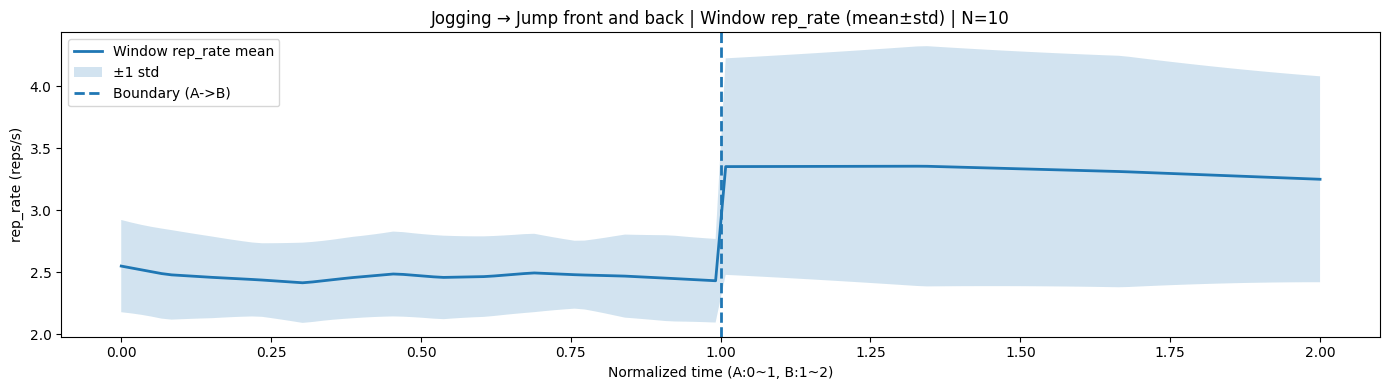

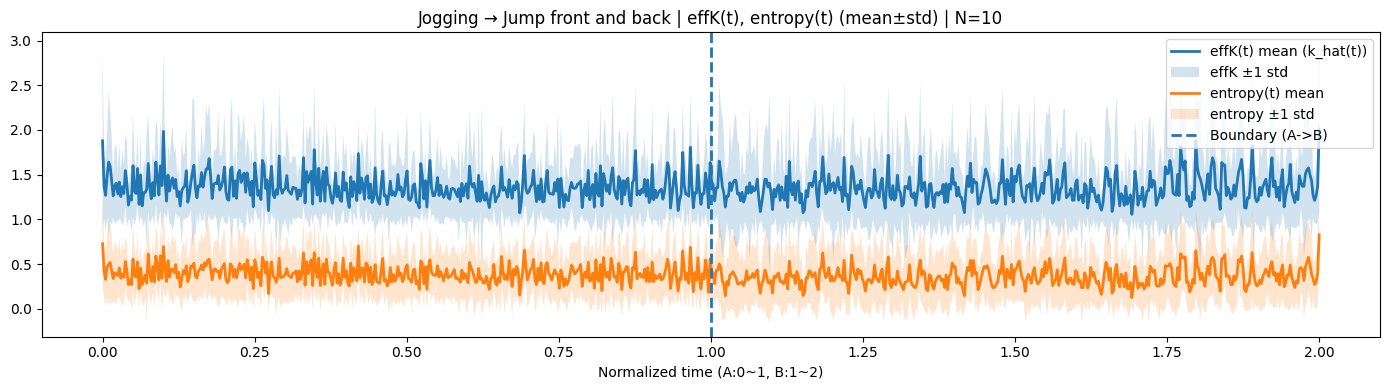

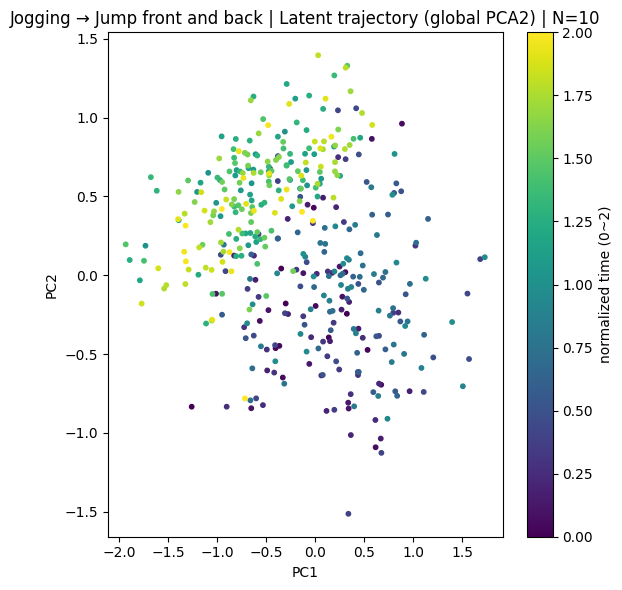


1. 시나리오2: Jump front and back → Jogging
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 1.103
 >>> Standard Deviation: 1.083
----------------------------------------------------------------------------------------------------
[Scenario] Jump front and back → Jogging | subject1 | Jump front & back(20) -> Jogging(157) | GT_total=177 | Pred(win)=79.00 | Diff=-98.00 | MAE=98.00 | k_hat(full)=2.60 | ent(full)=0.925 | boundary=1075
[Scenario] Jump front and back → Jogging | subject2 | Jump front & back(22) -> Jogging(161) | GT_total=183 | Pred(win)=115.93 | Diff=-67.07 | MAE=67.07 | k_hat(full)=1.64 | ent(full)=0.665 | boundary=1024
[Scenario] Jump front and back → Jogging | subject3 | Jump front & back(21) -> Jogging(154) | GT_total=175 | Pred(win)=84.44 | Diff=-90.56 | MAE=90.56 | k_hat(f

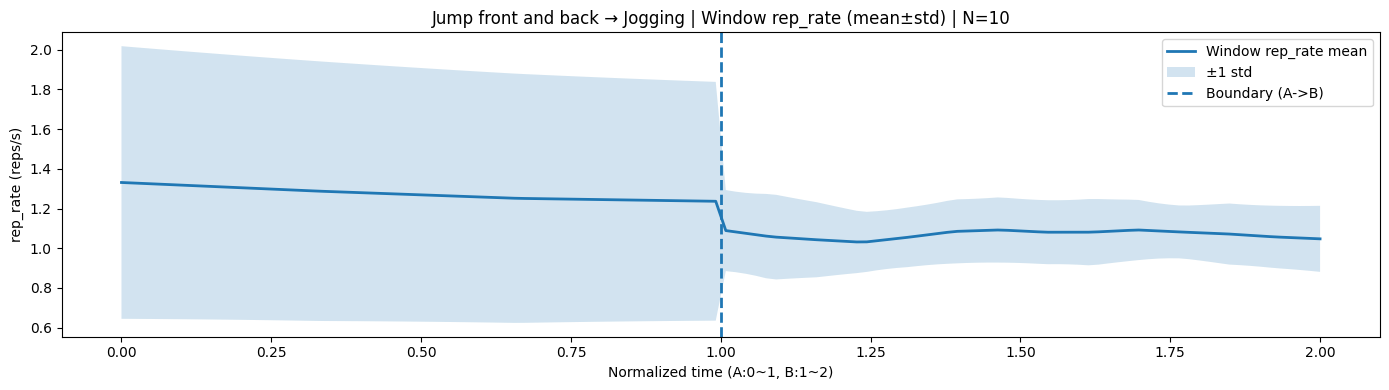

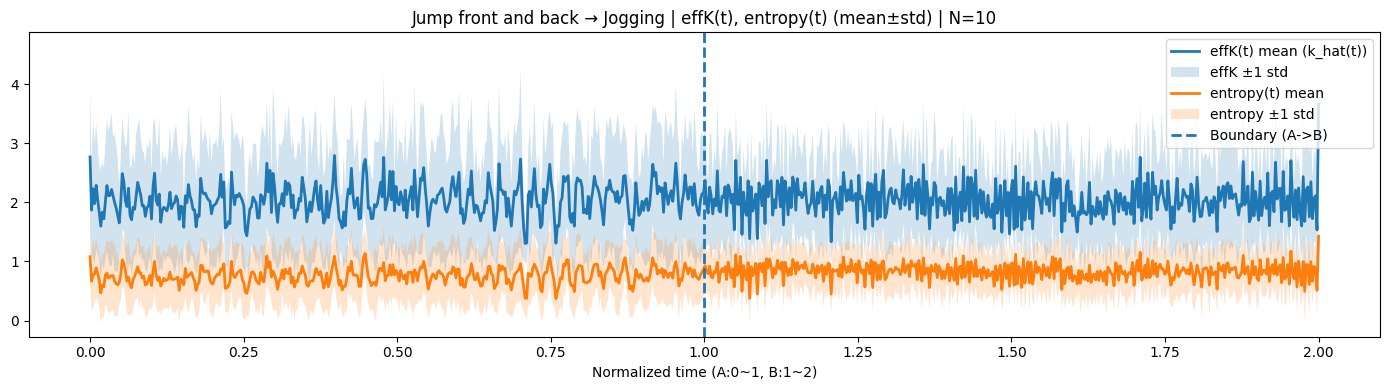

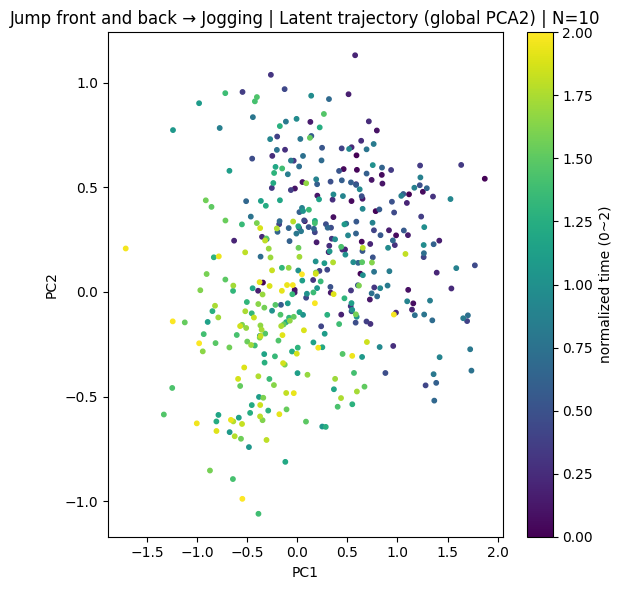

In [1]:
# =========================
# Count-only K-auto (Multi-event) + Windowing version
#
# ✅ Windowing added:
# - TRAIN: trial -> sliding windows (window-level count = trial-average rate * window duration)
# - TEST : trial 그대로 두고, windowing inference로 window rate 평균 -> 전체 count 예측
# - k_hat / entropy / rep_rate / phase heatmap은 (표현학습 확인용) full-trial 1회 forward로 기록
#
# ✅ (ADDED) Extension Scenario (TEST only):
# - raw signal concat A-B (single trials)
# - boundary index 저장 (meta)
# - GT_total = GT[A][subj] + GT[B][subj] (user-provided dict)
# - scenarios:
#   1) Knees bending -> Frontal elevation of arms
#   2) Waist bends forward -> Jump front & back
#
# - Scenario1(KB->FEA): TRAIN act = Knees bending (8)
# - Scenario2(WBF->JFB): TRAIN act = Waist bends forward (6)
# - GT_BY_ACT 기반이라 ALL_LABELS 없이 label_config 생성
# - raw concat 후 mixed 전체로 1회 z-score 정규화
# - 로그 포맷: 시나리오별로 Train Summary -> subject별 Scenario 라인(+MAE) -> Scenario Summary
#
# ✅ (UPDATED) Visualization:
# - subject별 plot 저장 X (너무 많음)
# - 시나리오당 딱 3장만 저장:
#   1) Window-level rep_rate mean±std (+ boundary)
#   2) effK(t)=k_hat(t), entropy(t) mean±std (+ boundary)
#   3) Latent trajectory (global PCA2) mean trajectory (+ std circle markers) (+ boundary marker)
# =========================

import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns  # kept
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # kept

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score 정규화 (표준화) 평균=0, std=1
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,              # (T, C)
                'count': float(gt_count),      # trial total count
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ---------------------------------------------------------------------
# ✅ Mixed A-B builder (raw concat + boundary meta)
#     - A/B raw concat 후 mixed 전체로 1회 z-score
#     - (ADDED) data_A / data_B : mixed 기준 정규화된 A/B segment
# ---------------------------------------------------------------------
def get_single_trial_from_full_data(subj, act_id, gt_count, full_data, target_map, feature_map, normalize=True):
    act_name = target_map.get(act_id)
    feats = feature_map.get(act_id)

    if subj not in full_data or act_name not in full_data[subj]:
        return None

    raw_df = full_data[subj][act_name][feats]
    x = raw_df.values.astype(np.float32)

    if normalize:
        mean = x.mean(axis=0)
        std = x.std(axis=0) + 1e-6
        x = (x - mean) / std

    return {
        "data": x,
        "count": float(gt_count),
        "meta": f"{subj}_{act_name}"
    }


def build_mixed_ab_trial(subj, actA_id, actB_id, config, full_data):
    gt_map = config.get("GT_BY_ACT", {})
    if actA_id not in gt_map or actB_id not in gt_map:
        return None
    if subj not in gt_map[actA_id] or subj not in gt_map[actB_id]:
        return None

    gtA = float(gt_map[actA_id][subj])
    gtB = float(gt_map[actB_id][subj])
    gt_total = gtA + gtB

    A = get_single_trial_from_full_data(
        subj, actA_id, gtA, full_data,
        config["TARGET_ACTIVITIES_MAP"], config["ACT_FEATURE_MAP"],
        normalize=False
    )
    B = get_single_trial_from_full_data(
        subj, actB_id, gtB, full_data,
        config["TARGET_ACTIVITIES_MAP"], config["ACT_FEATURE_MAP"],
        normalize=False
    )
    if A is None or B is None:
        return None

    xA_raw = A["data"]
    xB_raw = B["data"]
    boundary = int(xA_raw.shape[0])

    x_mix_raw = np.concatenate([xA_raw, xB_raw], axis=0).astype(np.float32)

    mean = x_mix_raw.mean(axis=0)
    std = x_mix_raw.std(axis=0) + 1e-6
    x_mix = (x_mix_raw - mean) / std

    # ✅ for A/B split analysis
    xA = (xA_raw - mean) / std
    xB = (xB_raw - mean) / std

    actA_name = config["TARGET_ACTIVITIES_MAP"].get(actA_id, str(actA_id))
    actB_name = config["TARGET_ACTIVITIES_MAP"].get(actB_id, str(actB_id))

    return {
        "data": x_mix,
        "count": float(gt_total),
        "meta": f"{subj}__{actA_name}__TO__{actB_name}",
        "boundary": boundary,
        "meta_detail": {
            "subj": subj,
            "actA_id": actA_id, "actB_id": actB_id,
            "actA_name": actA_name, "actB_name": actB_name,
            "gtA": gtA, "gtB": gtB,
            "gt_total": gt_total,
        },
        "data_A": xA,
        "data_B": xB,
        "T_A": int(xA.shape[0]),
        "T_B": int(xB.shape[0]),
    }


# ---------------------------------------------------------------------
# 2.5) ✅ Windowing (added)
# ---------------------------------------------------------------------
def trial_list_to_windows(trial_list, fs, win_sec=8.0, stride_sec=4.0, drop_last=True):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    assert win_len > 0 and stride > 0

    windows = []
    for item in trial_list:
        x = item["data"]
        T = x.shape[0]
        total_count = float(item["count"])
        meta = item["meta"]

        total_dur = max(T / float(fs), 1e-6)
        rate_trial = total_count / total_dur

        if T < win_len:
            win_dur = T / float(fs)
            windows.append({
                "data": x,
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[0:{T}]",
                "parent_meta": meta,
                "parent_T": T,
                "win_start": 0,
                "win_end": T,
            })
            continue

        last_start = T - win_len
        starts = list(range(0, last_start + 1, stride))

        for st in starts:
            ed = st + win_len
            win_dur = win_len / float(fs)
            windows.append({
                "data": x[st:ed],
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[{st}:{ed}]",
                "parent_meta": meta,
                "parent_T": T,
                "win_start": st,
                "win_end": ed,
            })

        if not drop_last:
            last_st = starts[-1] + stride
            if last_st < T:
                ed = T
                win_dur = (ed - last_st) / float(fs)
                windows.append({
                    "data": x[last_st:ed],
                    "count": rate_trial * win_dur,
                    "meta": f"{meta}__win[{last_st}:{ed}]",
                    "parent_meta": meta,
                    "parent_T": T,
                    "win_start": last_st,
                    "win_end": ed,
                })

    return windows


def predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]
    total_dur = T / float(fs)

    if T <= win_len:
        x_tensor = torch.tensor(x_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
        with torch.no_grad():
            rate_hat, _, _, _ = model(x_tensor, mask=None, tau=tau)
        pred_count = float(rate_hat.item() * total_dur)
        return pred_count, np.array([float(rate_hat.item())], dtype=np.float32)

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)

    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())

    rates = np.concatenate(rates, axis=0)
    rate_mean = float(rates.mean())
    pred_count = rate_mean * total_dur
    return float(pred_count), rates


# ---------------------------------------------------------------------
# ✅ (ADDED) Helpers for scenario-avg plots
# ---------------------------------------------------------------------
def get_window_rate_curve(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]

    if T <= win_len:
        pred_count, rates = predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=tau, batch_size=batch_size)
        t_cent = np.array([0.5 * (T / float(fs))], dtype=np.float32)
        return t_cent, rates.astype(np.float32)

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)

    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())
    rates = np.concatenate(rates, axis=0).astype(np.float32)

    centers = np.array([(st + 0.5 * win_len) / float(fs) for st in starts], dtype=np.float32)
    return centers, rates


def resample_1d(y, new_len):
    y = np.asarray(y, dtype=np.float32)
    if y.size == 0:
        return np.zeros((new_len,), dtype=np.float32)
    if y.size == 1:
        return np.full((new_len,), float(y[0]), dtype=np.float32)
    x_old = np.linspace(0.0, 1.0, num=y.size, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=new_len, dtype=np.float32)
    return np.interp(x_new, x_old, y).astype(np.float32)


def resample_2d(Y, new_len):
    Y = np.asarray(Y, dtype=np.float32)
    if Y.shape[0] == 0:
        return np.zeros((new_len, Y.shape[1]), dtype=np.float32)
    if Y.shape[0] == 1:
        return np.repeat(Y, repeats=new_len, axis=0).astype(np.float32)
    x_old = np.linspace(0.0, 1.0, num=Y.shape[0], dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=new_len, dtype=np.float32)
    out = []
    for d in range(Y.shape[1]):
        out.append(np.interp(x_new, x_old, Y[:, d]))
    return np.stack(out, axis=1).astype(np.float32)


def compute_entropy_t(phase_p_tk, eps=1e-8):
    phase_p_tk = np.asarray(phase_p_tk, dtype=np.float32)
    return (-(phase_p_tk * np.log(phase_p_tk + eps)).sum(axis=1)).astype(np.float32)


def compute_effk_t(phase_p_tk, eps=1e-6):
    phase_p_tk = np.asarray(phase_p_tk, dtype=np.float32)
    denom = (phase_p_tk ** 2).sum(axis=1) + eps
    return (1.0 / denom).astype(np.float32)


def global_pca2(Z_all):
    """
    Z_all: (N,D)
    returns: mean (D,), V2 (2,D)  such that proj = (Z-mean) @ V2.T
    """
    Z_all = np.asarray(Z_all, dtype=np.float32)
    mu = Z_all.mean(axis=0, keepdims=True)
    Zc = Z_all - mu
    _, _, Vt = np.linalg.svd(Zc, full_matrices=False)
    V2 = Vt[:2].astype(np.float32)  # (2,D)
    return mu.squeeze(0).astype(np.float32), V2


def plot_scenario_mean_std(
    save_dir,
    scen_name,
    fs,
    win_t, win_mean, win_std,
    eff_t, eff_mean, eff_std,
    ent_mean, ent_std,
    lat_xy_mean, lat_xy_std,
    n_subjects,
):
    # (1) Window-level rep_rate mean±std
    plt.figure(figsize=(14, 4))
    plt.plot(win_t, win_mean, linewidth=2, label="Window rep_rate mean")
    plt.fill_between(win_t, win_mean - win_std, win_mean + win_std, alpha=0.2, label="±1 std")
    plt.axvline(1.0, linestyle="--", linewidth=2, label="Boundary (A->B)")
    plt.xlabel("Normalized time (A:0~1, B:1~2)")
    plt.ylabel("rep_rate (reps/s)")
    plt.title(f"{scen_name} | Window rep_rate (mean±std) | N={n_subjects}")
    plt.legend()
    plt.tight_layout()
    plt.show()          # ✅ show로 변경
    # plt.close()       # (원하면 메모리 아끼려고 추가)

    # (2) effK(t) & entropy(t) mean±std
    plt.figure(figsize=(14, 4))
    plt.plot(eff_t, eff_mean, linewidth=2, label="effK(t) mean (k_hat(t))")
    plt.fill_between(eff_t, eff_mean - eff_std, eff_mean + eff_std, alpha=0.2, label="effK ±1 std")
    plt.plot(eff_t, ent_mean, linewidth=2, label="entropy(t) mean")
    plt.fill_between(eff_t, ent_mean - ent_std, ent_mean + ent_std, alpha=0.2, label="entropy ±1 std")
    plt.axvline(1.0, linestyle="--", linewidth=2, label="Boundary (A->B)")
    plt.xlabel("Normalized time (A:0~1, B:1~2)")
    plt.title(f"{scen_name} | effK(t), entropy(t) (mean±std) | N={n_subjects}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.close()

    # (3) Latent trajectory: scatter only
    plt.figure(figsize=(6, 6))
    t_lat = np.linspace(0.0, 2.0, num=lat_xy_mean.shape[0], dtype=np.float32)

    sc = plt.scatter(lat_xy_mean[:, 0], lat_xy_mean[:, 1], c=t_lat, s=10)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{scen_name} | Latent trajectory (global PCA2) | N={n_subjects}")
    plt.colorbar(sc, label="normalized time (0~2)")
    plt.tight_layout()
    plt.show()
    # plt.close()


# ---------------------------------------------------------------------
# 2.8) Dataset / Collate
# ---------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),
        "mask": torch.stack(masks),
        "count": torch.stack(counts),
        "length": torch.tensor(lengths, dtype=torch.float32),
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        z = self.net(x)            # (B, D, T)
        z = z.transpose(1, 2)      # (B, T, D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        zt = z.transpose(1, 2)
        x_hat = self.net(zt)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)
        )

    def forward(self, z, tau=1.0):
        out = self.net(z)
        amp = F.softplus(out[..., 0])
        phase_logits = out[..., 1:]
        phase = F.softmax(phase_logits / tau, dim=-1)
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6, k_hidden=64):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=tau)
        rates_k_t = amp_t.unsqueeze(-1) * phase_p

        micro_rate_t = amp_t

        p_bar = self._masked_mean_time(phase_p, mask)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)

        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "rates_k_t": rates_k_t,
            "phase_p": phase_p,
            "phase_logits": phase_logits,
            "micro_rate_t": micro_rate_t,
            "rep_rate_t": rep_rate_t,
            "k_hat": k_hat,
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)
    se = (x_hat - x) ** 2
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    dv = torch.abs(v[:, 1:] - v[:, :-1])
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    if mask is None:
        p_bar = phase_p.mean(dim=1)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)

    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean(), effK.detach()


def compute_phase_entropy_mean(phase_p_np, eps=1e-8):
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)
    ent_t = -(phase_p_np * np.log(phase_p_np + eps)).sum(axis=1)
    return float(ent_t.mean())


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in [
        'loss', 'loss_rate', 'loss_recon', 'loss_smooth', 'loss_phase_ent', 'loss_effk',
        'mae_count'
    ]}

    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)
        mask = batch["mask"].to(device)
        y_count = batch["count"].to(device)
        length = batch["length"].to(device)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration

        optimizer.zero_grad()
        rate_hat, z, x_hat, aux = model(x, mask, tau=tau)

        loss_rate = F.mse_loss(rate_hat, y_rate)
        loss_recon = masked_recon_mse(x_hat, x, mask)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)
        loss_effk, _ = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()

        count_hat = rate_hat * duration
        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['loss_smooth'] += loss_smooth.item()
        stats['loss_phase_ent'] += loss_phase_ent.item()
        stats['loss_effk'] += loss_effk.item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v / n for k, v in stats.items()}


# ---------------------------------------------------------------------
# 6) Main (Scenario-wise LOSO)
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            10: 'Jogging',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            10: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ]
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Windowing Params
        "win_sec": 8.0,
        "stride_sec": 4.0,
        "drop_last": True,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.0075,

        "tau": 1.0,

        "GT_BY_ACT": {
            10: {
                "subject1": 157, "subject2": 161, "subject3": 154, "subject4": 154, "subject5": 160,
                "subject6": 156, "subject7": 153, "subject8": 160, "subject9": 166, "subject10": 156,
            },
            12: {
                "subject1": 20, "subject2": 22, "subject3": 21, "subject4": 21, "subject5": 20,
                "subject6": 21, "subject7": 19, "subject8": 20, "subject9": 20, "subject10": 20,
            },
        },

        "MIX_SCENARIOS": [
            ("Jogging → Jump front and back", 10, 12),
            ("Jump front and back → Jogging", 12, 10)
        ],
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]

    # ✅ scenario-level visualization output directory
    VIZ_DIR = "scenario_viz"
    os.makedirs(VIZ_DIR, exist_ok=True)

    # resample lengths (fixed for averaging)
    NW = 60     # window-rate points per segment (A,B)
    NT = 400    # effK/entropy points per segment (A,B)
    NL = 200    # latent points per segment (A,B)

    # =========================================================
    # Scenario-wise execution
    # =========================================================
    for scen_idx, (scen_name, actA_id, actB_id) in enumerate(CONFIG.get("MIX_SCENARIOS", []), start=1):
        TRAIN_ACT_ID = actA_id

        print("\n" + "=" * 100)
        print(f"1. 시나리오{scen_idx}: {scen_name}")
        print("=" * 100)

        loso_results = []
        scenario_records = []
        scenario_diffs = []

        # ✅ (ADDED) buffers for scenario-avg plots
        buf_win_concat = []    # (2*NW,)
        buf_eff_concat = []    # (2*NT,)
        buf_ent_concat = []    # (2*NT,)
        buf_z_concat = []      # raw z(t) list for global PCA: (Tmix,D) per subject
        buf_boundary_ratio = []  # not used (boundary fixed at 1 after normalization)

        # Keep per-subject z for later per-subject projection & resample
        per_subject_latent = []  # dicts with zA,zB (raw D)

        for fold_idx, test_subj in enumerate(subjects):
            set_strict_seed(CONFIG["seed"])

            gt_train_map = CONFIG["GT_BY_ACT"][TRAIN_ACT_ID]
            train_labels = [(s, TRAIN_ACT_ID, gt_train_map[s]) for s in subjects if s != test_subj]
            test_labels  = [(test_subj, TRAIN_ACT_ID, gt_train_map[test_subj])]

            train_trials = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
            test_trials  = prepare_trial_list(test_labels,  full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
            if not test_trials or not train_trials:
                continue

            train_data = trial_list_to_windows(
                train_trials, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                drop_last=CONFIG["drop_last"]
            )

            g = torch.Generator()
            g.manual_seed(CONFIG["seed"])

            train_loader = DataLoader(
                TrialDataset(train_data),
                batch_size=CONFIG["batch_size"],
                shuffle=True,
                collate_fn=collate_variable_length,
                generator=g,
                num_workers=0
            )

            input_ch = train_data[0]['data'].shape[1]
            model = KAutoCountModel(
                input_ch=input_ch,
                hidden_dim=CONFIG["hidden_dim"],
                latent_dim=CONFIG["latent_dim"],
                K_max=CONFIG["K_max"]
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

            for epoch in range(CONFIG["epochs"]):
                _ = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
                scheduler.step()

            model.eval()

            # (A) LOSO on TRAIN_ACT_ID
            item = test_trials[0]
            x_np = item["data"]
            count_gt = float(item["count"])
            count_pred_win, _ = predict_count_by_windowing(
                model, x_np=x_np,
                fs=CONFIG["fs"], win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )
            fold_mae = float(abs(count_pred_win - count_gt))
            loso_results.append(fold_mae)

            # (B) Scenario eval
            mixed_item = build_mixed_ab_trial(test_subj, actA_id, actB_id, CONFIG, full_data)
            if mixed_item is None:
                continue

            x_mix = mixed_item["data"]
            boundary = mixed_item["boundary"]
            gt_total = float(mixed_item["count"])
            md = mixed_item["meta_detail"]

            pred_total, _ = predict_count_by_windowing(
                model, x_np=x_mix,
                fs=CONFIG["fs"], win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )

            diff = float(pred_total - gt_total)
            mae = float(abs(diff))
            scenario_diffs.append(diff)

            # full forward for phase/rep_rate/z
            x_tensor = torch.tensor(x_mix, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
            with torch.no_grad():
                _, z_m, _, aux_m = model(x_tensor, mask=None, tau=CONFIG.get("tau", 1.0))

            phase_p_m = aux_m["phase_p"].squeeze(0).detach().cpu().numpy()  # (Tmix,K)
            k_hat_m = float(aux_m["k_hat"].item())
            ent_m = compute_phase_entropy_mean(phase_p_m)

            z_td = z_m.squeeze(0).detach().cpu().numpy()  # (Tmix,D)

            scenario_records.append({
                "subj": test_subj,
                "line": (
                    f"[Scenario] {scen_name} | {test_subj} | "
                    f"{md['actA_name']}({md['gtA']:.0f}) -> {md['actB_name']}({md['gtB']:.0f}) | "
                    f"GT_total={gt_total:.0f} | Pred(win)={pred_total:.2f} | Diff={diff:+.2f} | "
                    f"MAE={mae:.2f} | k_hat(full)={k_hat_m:.2f} | ent(full)={ent_m:.3f} | boundary={boundary}"
                )
            })

            # ===========================
            # ✅ (UPDATED) buffers for scenario-avg plots
            # ===========================
            # 1) window-level rep_rate curves (A/B separately -> resample -> concat to [0,2])
            xA = mixed_item["data_A"]
            xB = mixed_item["data_B"]

            _, rA_w = get_window_rate_curve(
                model, xA, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )
            _, rB_w = get_window_rate_curve(
                model, xB, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )

            rA_rs = resample_1d(rA_w, NW)
            rB_rs = resample_1d(rB_w, NW)
            buf_win_concat.append(np.concatenate([rA_rs, rB_rs], axis=0))  # (2*NW,)

            # 2) effK(t), entropy(t) from phase_p split A/B -> resample -> concat to [0,2]
            effk_t = compute_effk_t(phase_p_m)     # (Tmix,)
            ent_t = compute_entropy_t(phase_p_m)   # (Tmix,)

            effA = effk_t[:boundary]
            effB = effk_t[boundary:]
            entA = ent_t[:boundary]
            entB = ent_t[boundary:]

            effA_rs = resample_1d(effA, NT)
            effB_rs = resample_1d(effB, NT)
            entA_rs = resample_1d(entA, NT)
            entB_rs = resample_1d(entB, NT)

            buf_eff_concat.append(np.concatenate([effA_rs, effB_rs], axis=0))  # (2*NT,)
            buf_ent_concat.append(np.concatenate([entA_rs, entB_rs], axis=0))  # (2*NT,)

            # 3) latent: store raw z split for global PCA projection later
            zA = z_td[:boundary, :]
            zB = z_td[boundary:, :]
            buf_z_concat.append(z_td)
            per_subject_latent.append({"zA": zA, "zB": zB})

        # ---------------------------------------------------------
        # Printing: Train summary -> subject lines -> scenario summary
        # ---------------------------------------------------------
        print("-" * 100)
        if len(loso_results) > 0:
            print("TRain 결과 ->")
            print("-" * 100)
            print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
            print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
            print("-" * 100)
        else:
            print("TRain 결과 -> (no folds computed)")
            print("-" * 100)

        subj2line = {r["subj"]: r["line"] for r in scenario_records}
        for s in subjects:
            if s in subj2line:
                print(subj2line[s])

        print("\n" + "-" * 100)
        print(f"시나리오{scen_idx} 결과")
        print("-" * 100)

        if len(scenario_diffs) == 0:
            print(f"[{scen_name}] No samples (all skipped). Fill GT_BY_ACT for required activities.")
        else:
            diffs = np.array(scenario_diffs, dtype=np.float32)
            mae = float(np.mean(np.abs(diffs)))
            rmse = float(np.sqrt(np.mean(diffs ** 2)))
            print(f"[{scen_name}] N={len(diffs):2d} | MAE={mae:.3f} | RMSE={rmse:.3f} | mean(diff)={diffs.mean():+.3f} | std(diff)={diffs.std():.3f}")
        print("-" * 100)

        # ---------------------------------------------------------
        # ✅ (UPDATED) Scenario-level mean±std plots (only 3 files)
        # ---------------------------------------------------------
        n_ok = len(buf_win_concat)
        if n_ok == 0:
            print("[Viz Skip] No scenario samples collected for averaging.")
            continue

        # (1) window-level mean±std on normalized axis [0,2]
        W = np.stack(buf_win_concat, axis=0)  # (N, 2*NW)
        win_mean = W.mean(axis=0)
        win_std  = W.std(axis=0)
        win_t = np.linspace(0.0, 2.0, num=2*NW, dtype=np.float32)

        # (2) effK/entropy mean±std on normalized axis [0,2]
        EFF = np.stack(buf_eff_concat, axis=0)  # (N, 2*NT)
        ENT = np.stack(buf_ent_concat, axis=0)  # (N, 2*NT)
        eff_mean = EFF.mean(axis=0)
        eff_std  = EFF.std(axis=0)
        ent_mean = ENT.mean(axis=0)
        ent_std  = ENT.std(axis=0)
        eff_t = np.linspace(0.0, 2.0, num=2*NT, dtype=np.float32)

        # (3) latent: global PCA basis from all z
        Z_all = np.concatenate(buf_z_concat, axis=0)  # (sumT, D)
        mu, V2 = global_pca2(Z_all)

        # project each subject, resample A/B to NL then concat -> (2*NL,2)
        lat_list = []
        for d in per_subject_latent:
            zA = d["zA"]; zB = d["zB"]
            pcA = (zA - mu) @ V2.T  # (TA,2)
            pcB = (zB - mu) @ V2.T  # (TB,2)
            pcA_rs = resample_2d(pcA, NL)
            pcB_rs = resample_2d(pcB, NL)
            lat_list.append(np.concatenate([pcA_rs, pcB_rs], axis=0))  # (2*NL,2)

        LAT = np.stack(lat_list, axis=0)  # (N,2*NL,2)
        lat_xy_mean = LAT.mean(axis=0)    # (2*NL,2)
        lat_xy_std  = LAT.std(axis=0)     # (2*NL,2)

        plot_scenario_mean_std(
            save_dir=None,  # 혹은 인자 자체 제거
            scen_name=scen_name,
            fs=CONFIG["fs"],
            win_t=win_t, win_mean=win_mean, win_std=win_std,
            eff_t=eff_t, eff_mean=eff_mean, eff_std=eff_std,
            ent_mean=ent_mean, ent_std=ent_std,
            lat_xy_mean=lat_xy_mean, lat_xy_std=lat_xy_std,
            n_subjects=n_ok
        )

if __name__ == "__main__":
    main()


Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

1. 시나리오1: Jogging → Running
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 10.421
 >>> Standard Deviation: 10.920
----------------------------------------------------------------------------------------------------
[Scenario] Jogging → Running | subject1 | Jogging(157) -> Running(165) | GT_total=322 | Pred(win)=321.54 | Diff=-0.46 | MAE=0.46 | k_hat(full)=1.23 | ent(full)=0.311 | boundary=3072
[Scenario] Jogging → Running | subject2 | Jogging(161) -> Running(158) | GT_total=319 | Pred(win)=338.97 | Diff=+19.97 | MAE=19.97 | k_hat(full)=1.73 | ent(full)=0.485 | boundary=3072
[Scenario] Jogging → Running | subject3 | Jogging(154) -> Running(174) | GT_total=328 | Pred(win)=335.16 | Di

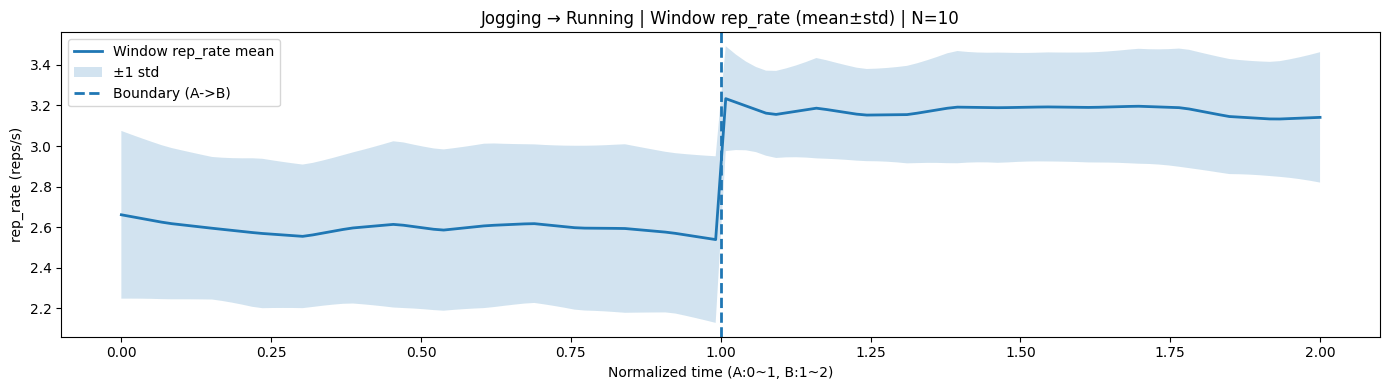

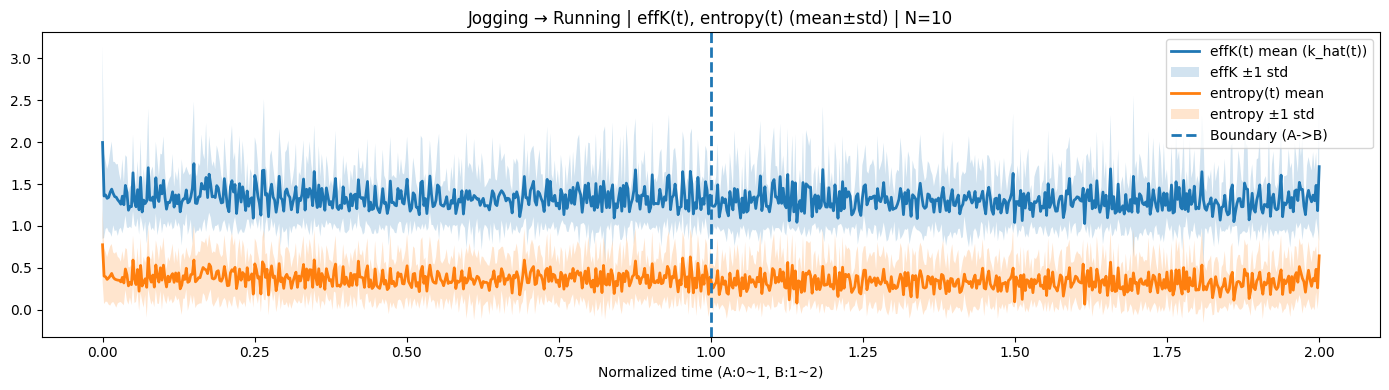

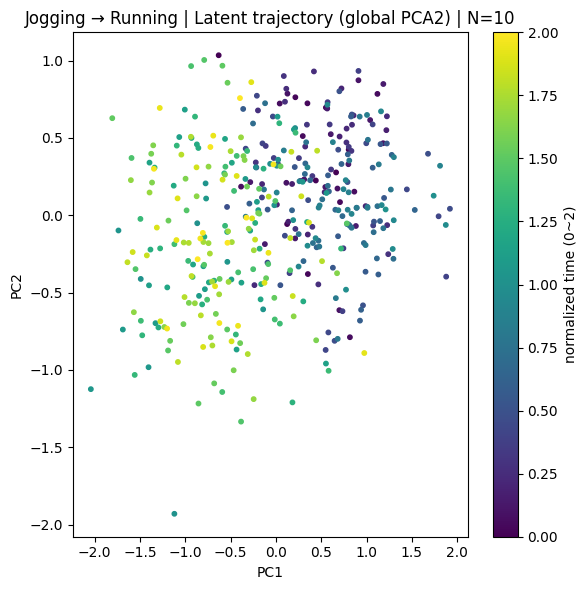


1. 시나리오2: Running → Jogging
----------------------------------------------------------------------------------------------------
TRain 결과 ->
----------------------------------------------------------------------------------------------------
 >>> Final LOSO Result (Average MAE): 15.211
 >>> Standard Deviation: 7.371
----------------------------------------------------------------------------------------------------
[Scenario] Running → Jogging | subject1 | Running(165) -> Jogging(157) | GT_total=322 | Pred(win)=317.94 | Diff=-4.06 | MAE=4.06 | k_hat(full)=1.62 | ent(full)=0.321 | boundary=3072
[Scenario] Running → Jogging | subject2 | Running(158) -> Jogging(161) | GT_total=319 | Pred(win)=344.19 | Diff=+25.19 | MAE=25.19 | k_hat(full)=1.96 | ent(full)=0.327 | boundary=3072
[Scenario] Running → Jogging | subject3 | Running(174) -> Jogging(154) | GT_total=328 | Pred(win)=368.21 | Diff=+40.21 | MAE=40.21 | k_hat(full)=1.31 | ent(full)=0.272 | boundary=3072
[Scenario] Running → Jogging |

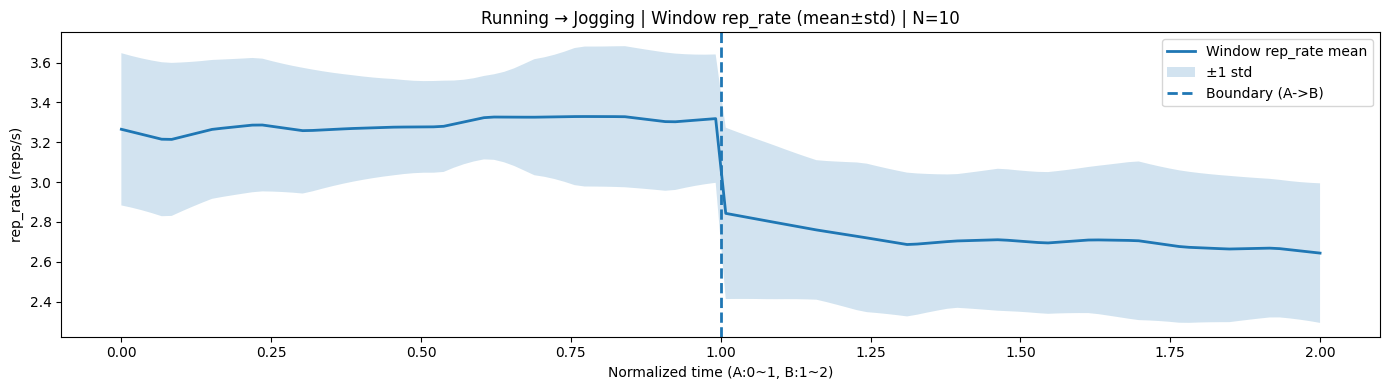

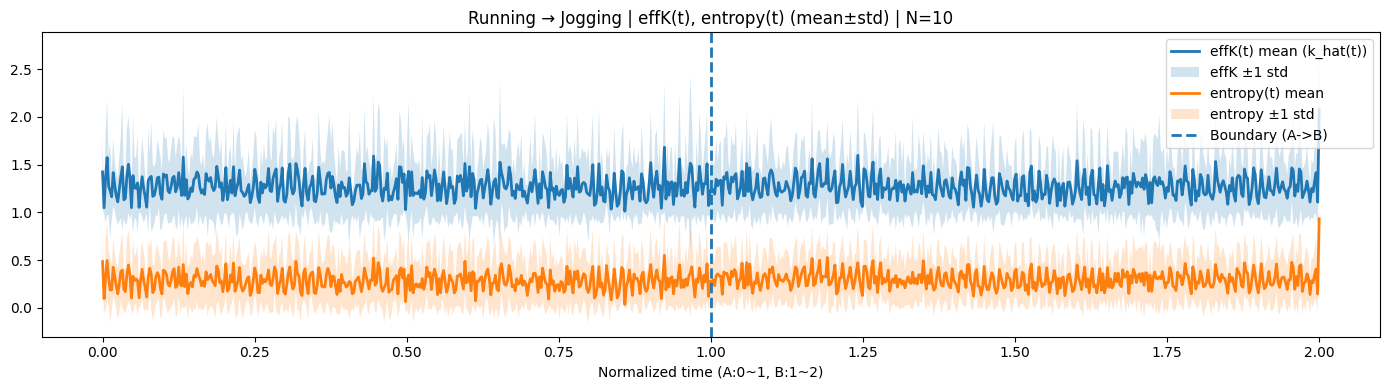

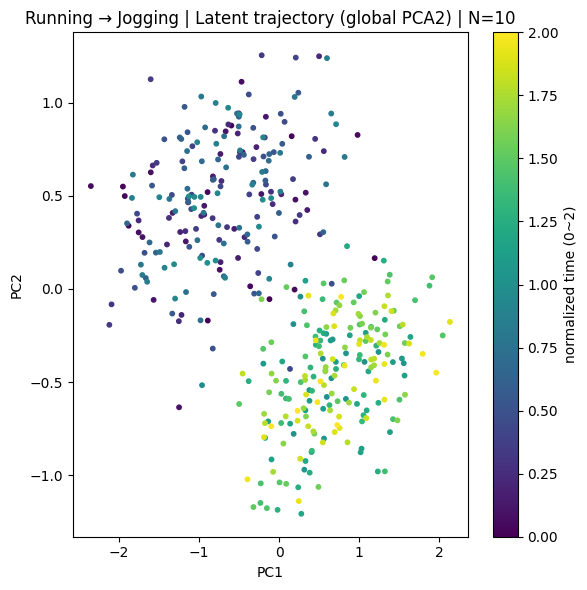

In [2]:
# =========================
# Count-only K-auto (Multi-event) + Windowing version
#
# ✅ Windowing added:
# - TRAIN: trial -> sliding windows (window-level count = trial-average rate * window duration)
# - TEST : trial 그대로 두고, windowing inference로 window rate 평균 -> 전체 count 예측
# - k_hat / entropy / rep_rate / phase heatmap은 (표현학습 확인용) full-trial 1회 forward로 기록
#
# ✅ (ADDED) Extension Scenario (TEST only):
# - raw signal concat A-B (single trials)
# - boundary index 저장 (meta)
# - GT_total = GT[A][subj] + GT[B][subj] (user-provided dict)
# - scenarios:
#   1) Knees bending -> Frontal elevation of arms
#   2) Waist bends forward -> Jump front & back
#
# - Scenario1(KB->FEA): TRAIN act = Knees bending (8)
# - Scenario2(WBF->JFB): TRAIN act = Waist bends forward (6)
# - GT_BY_ACT 기반이라 ALL_LABELS 없이 label_config 생성
# - raw concat 후 mixed 전체로 1회 z-score 정규화
# - 로그 포맷: 시나리오별로 Train Summary -> subject별 Scenario 라인(+MAE) -> Scenario Summary
#
# ✅ (UPDATED) Visualization:
# - subject별 plot 저장 X (너무 많음)
# - 시나리오당 딱 3장만 저장:
#   1) Window-level rep_rate mean±std (+ boundary)
#   2) effK(t)=k_hat(t), entropy(t) mean±std (+ boundary)
#   3) Latent trajectory (global PCA2) mean trajectory (+ std circle markers) (+ boundary marker)
# =========================

import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns  # kept
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # kept

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score 정규화 (표준화) 평균=0, std=1
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,              # (T, C)
                'count': float(gt_count),      # trial total count
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ---------------------------------------------------------------------
# ✅ Mixed A-B builder (raw concat + boundary meta)
#     - A/B raw concat 후 mixed 전체로 1회 z-score
#     - (ADDED) data_A / data_B : mixed 기준 정규화된 A/B segment
# ---------------------------------------------------------------------
def get_single_trial_from_full_data(subj, act_id, gt_count, full_data, target_map, feature_map, normalize=True):
    act_name = target_map.get(act_id)
    feats = feature_map.get(act_id)

    if subj not in full_data or act_name not in full_data[subj]:
        return None

    raw_df = full_data[subj][act_name][feats]
    x = raw_df.values.astype(np.float32)

    if normalize:
        mean = x.mean(axis=0)
        std = x.std(axis=0) + 1e-6
        x = (x - mean) / std

    return {
        "data": x,
        "count": float(gt_count),
        "meta": f"{subj}_{act_name}"
    }


def build_mixed_ab_trial(subj, actA_id, actB_id, config, full_data):
    gt_map = config.get("GT_BY_ACT", {})
    if actA_id not in gt_map or actB_id not in gt_map:
        return None
    if subj not in gt_map[actA_id] or subj not in gt_map[actB_id]:
        return None

    gtA = float(gt_map[actA_id][subj])
    gtB = float(gt_map[actB_id][subj])
    gt_total = gtA + gtB

    A = get_single_trial_from_full_data(
        subj, actA_id, gtA, full_data,
        config["TARGET_ACTIVITIES_MAP"], config["ACT_FEATURE_MAP"],
        normalize=False
    )
    B = get_single_trial_from_full_data(
        subj, actB_id, gtB, full_data,
        config["TARGET_ACTIVITIES_MAP"], config["ACT_FEATURE_MAP"],
        normalize=False
    )
    if A is None or B is None:
        return None

    xA_raw = A["data"]
    xB_raw = B["data"]
    boundary = int(xA_raw.shape[0])

    x_mix_raw = np.concatenate([xA_raw, xB_raw], axis=0).astype(np.float32)

    mean = x_mix_raw.mean(axis=0)
    std = x_mix_raw.std(axis=0) + 1e-6
    x_mix = (x_mix_raw - mean) / std

    # ✅ for A/B split analysis
    xA = (xA_raw - mean) / std
    xB = (xB_raw - mean) / std

    actA_name = config["TARGET_ACTIVITIES_MAP"].get(actA_id, str(actA_id))
    actB_name = config["TARGET_ACTIVITIES_MAP"].get(actB_id, str(actB_id))

    return {
        "data": x_mix,
        "count": float(gt_total),
        "meta": f"{subj}__{actA_name}__TO__{actB_name}",
        "boundary": boundary,
        "meta_detail": {
            "subj": subj,
            "actA_id": actA_id, "actB_id": actB_id,
            "actA_name": actA_name, "actB_name": actB_name,
            "gtA": gtA, "gtB": gtB,
            "gt_total": gt_total,
        },
        "data_A": xA,
        "data_B": xB,
        "T_A": int(xA.shape[0]),
        "T_B": int(xB.shape[0]),
    }


# ---------------------------------------------------------------------
# 2.5) ✅ Windowing (added)
# ---------------------------------------------------------------------
def trial_list_to_windows(trial_list, fs, win_sec=8.0, stride_sec=4.0, drop_last=True):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    assert win_len > 0 and stride > 0

    windows = []
    for item in trial_list:
        x = item["data"]
        T = x.shape[0]
        total_count = float(item["count"])
        meta = item["meta"]

        total_dur = max(T / float(fs), 1e-6)
        rate_trial = total_count / total_dur

        if T < win_len:
            win_dur = T / float(fs)
            windows.append({
                "data": x,
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[0:{T}]",
                "parent_meta": meta,
                "parent_T": T,
                "win_start": 0,
                "win_end": T,
            })
            continue

        last_start = T - win_len
        starts = list(range(0, last_start + 1, stride))

        for st in starts:
            ed = st + win_len
            win_dur = win_len / float(fs)
            windows.append({
                "data": x[st:ed],
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[{st}:{ed}]",
                "parent_meta": meta,
                "parent_T": T,
                "win_start": st,
                "win_end": ed,
            })

        if not drop_last:
            last_st = starts[-1] + stride
            if last_st < T:
                ed = T
                win_dur = (ed - last_st) / float(fs)
                windows.append({
                    "data": x[last_st:ed],
                    "count": rate_trial * win_dur,
                    "meta": f"{meta}__win[{last_st}:{ed}]",
                    "parent_meta": meta,
                    "parent_T": T,
                    "win_start": last_st,
                    "win_end": ed,
                })

    return windows


def predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]
    total_dur = T / float(fs)

    if T <= win_len:
        x_tensor = torch.tensor(x_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
        with torch.no_grad():
            rate_hat, _, _, _ = model(x_tensor, mask=None, tau=tau)
        pred_count = float(rate_hat.item() * total_dur)
        return pred_count, np.array([float(rate_hat.item())], dtype=np.float32)

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)

    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())

    rates = np.concatenate(rates, axis=0)
    rate_mean = float(rates.mean())
    pred_count = rate_mean * total_dur
    return float(pred_count), rates


# ---------------------------------------------------------------------
# ✅ (ADDED) Helpers for scenario-avg plots
# ---------------------------------------------------------------------
def get_window_rate_curve(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]

    if T <= win_len:
        pred_count, rates = predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=tau, batch_size=batch_size)
        t_cent = np.array([0.5 * (T / float(fs))], dtype=np.float32)
        return t_cent, rates.astype(np.float32)

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)

    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())
    rates = np.concatenate(rates, axis=0).astype(np.float32)

    centers = np.array([(st + 0.5 * win_len) / float(fs) for st in starts], dtype=np.float32)
    return centers, rates


def resample_1d(y, new_len):
    y = np.asarray(y, dtype=np.float32)
    if y.size == 0:
        return np.zeros((new_len,), dtype=np.float32)
    if y.size == 1:
        return np.full((new_len,), float(y[0]), dtype=np.float32)
    x_old = np.linspace(0.0, 1.0, num=y.size, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=new_len, dtype=np.float32)
    return np.interp(x_new, x_old, y).astype(np.float32)


def resample_2d(Y, new_len):
    Y = np.asarray(Y, dtype=np.float32)
    if Y.shape[0] == 0:
        return np.zeros((new_len, Y.shape[1]), dtype=np.float32)
    if Y.shape[0] == 1:
        return np.repeat(Y, repeats=new_len, axis=0).astype(np.float32)
    x_old = np.linspace(0.0, 1.0, num=Y.shape[0], dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=new_len, dtype=np.float32)
    out = []
    for d in range(Y.shape[1]):
        out.append(np.interp(x_new, x_old, Y[:, d]))
    return np.stack(out, axis=1).astype(np.float32)


def compute_entropy_t(phase_p_tk, eps=1e-8):
    phase_p_tk = np.asarray(phase_p_tk, dtype=np.float32)
    return (-(phase_p_tk * np.log(phase_p_tk + eps)).sum(axis=1)).astype(np.float32)


def compute_effk_t(phase_p_tk, eps=1e-6):
    phase_p_tk = np.asarray(phase_p_tk, dtype=np.float32)
    denom = (phase_p_tk ** 2).sum(axis=1) + eps
    return (1.0 / denom).astype(np.float32)


def global_pca2(Z_all):
    """
    Z_all: (N,D)
    returns: mean (D,), V2 (2,D)  such that proj = (Z-mean) @ V2.T
    """
    Z_all = np.asarray(Z_all, dtype=np.float32)
    mu = Z_all.mean(axis=0, keepdims=True)
    Zc = Z_all - mu
    _, _, Vt = np.linalg.svd(Zc, full_matrices=False)
    V2 = Vt[:2].astype(np.float32)  # (2,D)
    return mu.squeeze(0).astype(np.float32), V2


def plot_scenario_mean_std(
    save_dir,
    scen_name,
    fs,
    win_t, win_mean, win_std,
    eff_t, eff_mean, eff_std,
    ent_mean, ent_std,
    lat_xy_mean, lat_xy_std,
    n_subjects,
):
    # (1) Window-level rep_rate mean±std
    plt.figure(figsize=(14, 4))
    plt.plot(win_t, win_mean, linewidth=2, label="Window rep_rate mean")
    plt.fill_between(win_t, win_mean - win_std, win_mean + win_std, alpha=0.2, label="±1 std")
    plt.axvline(1.0, linestyle="--", linewidth=2, label="Boundary (A->B)")
    plt.xlabel("Normalized time (A:0~1, B:1~2)")
    plt.ylabel("rep_rate (reps/s)")
    plt.title(f"{scen_name} | Window rep_rate (mean±std) | N={n_subjects}")
    plt.legend()
    plt.tight_layout()
    plt.show()          # ✅ show로 변경
    # plt.close()       # (원하면 메모리 아끼려고 추가)

    # (2) effK(t) & entropy(t) mean±std
    plt.figure(figsize=(14, 4))
    plt.plot(eff_t, eff_mean, linewidth=2, label="effK(t) mean (k_hat(t))")
    plt.fill_between(eff_t, eff_mean - eff_std, eff_mean + eff_std, alpha=0.2, label="effK ±1 std")
    plt.plot(eff_t, ent_mean, linewidth=2, label="entropy(t) mean")
    plt.fill_between(eff_t, ent_mean - ent_std, ent_mean + ent_std, alpha=0.2, label="entropy ±1 std")
    plt.axvline(1.0, linestyle="--", linewidth=2, label="Boundary (A->B)")
    plt.xlabel("Normalized time (A:0~1, B:1~2)")
    plt.title(f"{scen_name} | effK(t), entropy(t) (mean±std) | N={n_subjects}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.close()

    # (3) Latent trajectory: scatter only
    plt.figure(figsize=(6, 6))
    t_lat = np.linspace(0.0, 2.0, num=lat_xy_mean.shape[0], dtype=np.float32)

    sc = plt.scatter(lat_xy_mean[:, 0], lat_xy_mean[:, 1], c=t_lat, s=10)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{scen_name} | Latent trajectory (global PCA2) | N={n_subjects}")
    plt.colorbar(sc, label="normalized time (0~2)")
    plt.tight_layout()
    plt.show()
    # plt.close()


# ---------------------------------------------------------------------
# 2.8) Dataset / Collate
# ---------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),
        "mask": torch.stack(masks),
        "count": torch.stack(counts),
        "length": torch.tensor(lengths, dtype=torch.float32),
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        z = self.net(x)            # (B, D, T)
        z = z.transpose(1, 2)      # (B, T, D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        zt = z.transpose(1, 2)
        x_hat = self.net(zt)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)
        )

    def forward(self, z, tau=1.0):
        out = self.net(z)
        amp = F.softplus(out[..., 0])
        phase_logits = out[..., 1:]
        phase = F.softmax(phase_logits / tau, dim=-1)
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6, k_hidden=64):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=tau)
        rates_k_t = amp_t.unsqueeze(-1) * phase_p

        micro_rate_t = amp_t

        p_bar = self._masked_mean_time(phase_p, mask)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)

        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "rates_k_t": rates_k_t,
            "phase_p": phase_p,
            "phase_logits": phase_logits,
            "micro_rate_t": micro_rate_t,
            "rep_rate_t": rep_rate_t,
            "k_hat": k_hat,
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)
    se = (x_hat - x) ** 2
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    dv = torch.abs(v[:, 1:] - v[:, :-1])
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    if mask is None:
        p_bar = phase_p.mean(dim=1)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)

    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean(), effK.detach()


def compute_phase_entropy_mean(phase_p_np, eps=1e-8):
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)
    ent_t = -(phase_p_np * np.log(phase_p_np + eps)).sum(axis=1)
    return float(ent_t.mean())


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in [
        'loss', 'loss_rate', 'loss_recon', 'loss_smooth', 'loss_phase_ent', 'loss_effk',
        'mae_count'
    ]}

    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)
        mask = batch["mask"].to(device)
        y_count = batch["count"].to(device)
        length = batch["length"].to(device)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration

        optimizer.zero_grad()
        rate_hat, z, x_hat, aux = model(x, mask, tau=tau)

        loss_rate = F.mse_loss(rate_hat, y_rate)
        loss_recon = masked_recon_mse(x_hat, x, mask)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)
        loss_effk, _ = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()

        count_hat = rate_hat * duration
        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['loss_smooth'] += loss_smooth.item()
        stats['loss_phase_ent'] += loss_phase_ent.item()
        stats['loss_effk'] += loss_effk.item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v / n for k, v in stats.items()}


# ---------------------------------------------------------------------
# 6) Main (Scenario-wise LOSO)
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            10: 'Jogging',
            11: 'Running',
        },
        "ACT_FEATURE_MAP": {
            10: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            11: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ]
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Windowing Params
        "win_sec": 8.0,
        "stride_sec": 4.0,
        "drop_last": True,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.0075,

        "tau": 1.0,

        "GT_BY_ACT": {
            10: {
                "subject1": 157, "subject2": 161, "subject3": 154, "subject4": 154, "subject5": 160,
                "subject6": 156, "subject7": 153, "subject8": 160, "subject9": 166, "subject10": 156,
            },
            11: {
                "subject1": 165, "subject2": 158, "subject3": 174, "subject4": 163, "subject5": 157,
                "subject6": 172, "subject7": 149, "subject8": 166, "subject9": 174, "subject10": 172,
            },
        },

        "MIX_SCENARIOS": [
            ("Jogging → Running", 10, 11),
            ("Running → Jogging", 11, 10)
        ],
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]

    # ✅ scenario-level visualization output directory
    VIZ_DIR = "scenario_viz"
    os.makedirs(VIZ_DIR, exist_ok=True)

    # resample lengths (fixed for averaging)
    NW = 60     # window-rate points per segment (A,B)
    NT = 400    # effK/entropy points per segment (A,B)
    NL = 200    # latent points per segment (A,B)

    # =========================================================
    # Scenario-wise execution
    # =========================================================
    for scen_idx, (scen_name, actA_id, actB_id) in enumerate(CONFIG.get("MIX_SCENARIOS", []), start=1):
        TRAIN_ACT_ID = actA_id

        print("\n" + "=" * 100)
        print(f"1. 시나리오{scen_idx}: {scen_name}")
        print("=" * 100)

        loso_results = []
        scenario_records = []
        scenario_diffs = []

        # ✅ (ADDED) buffers for scenario-avg plots
        buf_win_concat = []    # (2*NW,)
        buf_eff_concat = []    # (2*NT,)
        buf_ent_concat = []    # (2*NT,)
        buf_z_concat = []      # raw z(t) list for global PCA: (Tmix,D) per subject
        buf_boundary_ratio = []  # not used (boundary fixed at 1 after normalization)

        # Keep per-subject z for later per-subject projection & resample
        per_subject_latent = []  # dicts with zA,zB (raw D)

        for fold_idx, test_subj in enumerate(subjects):
            set_strict_seed(CONFIG["seed"])

            gt_train_map = CONFIG["GT_BY_ACT"][TRAIN_ACT_ID]
            train_labels = [(s, TRAIN_ACT_ID, gt_train_map[s]) for s in subjects if s != test_subj]
            test_labels  = [(test_subj, TRAIN_ACT_ID, gt_train_map[test_subj])]

            train_trials = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
            test_trials  = prepare_trial_list(test_labels,  full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
            if not test_trials or not train_trials:
                continue

            train_data = trial_list_to_windows(
                train_trials, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                drop_last=CONFIG["drop_last"]
            )

            g = torch.Generator()
            g.manual_seed(CONFIG["seed"])

            train_loader = DataLoader(
                TrialDataset(train_data),
                batch_size=CONFIG["batch_size"],
                shuffle=True,
                collate_fn=collate_variable_length,
                generator=g,
                num_workers=0
            )

            input_ch = train_data[0]['data'].shape[1]
            model = KAutoCountModel(
                input_ch=input_ch,
                hidden_dim=CONFIG["hidden_dim"],
                latent_dim=CONFIG["latent_dim"],
                K_max=CONFIG["K_max"]
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

            for epoch in range(CONFIG["epochs"]):
                _ = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
                scheduler.step()

            model.eval()

            # (A) LOSO on TRAIN_ACT_ID
            item = test_trials[0]
            x_np = item["data"]
            count_gt = float(item["count"])
            count_pred_win, _ = predict_count_by_windowing(
                model, x_np=x_np,
                fs=CONFIG["fs"], win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )
            fold_mae = float(abs(count_pred_win - count_gt))
            loso_results.append(fold_mae)

            # (B) Scenario eval
            mixed_item = build_mixed_ab_trial(test_subj, actA_id, actB_id, CONFIG, full_data)
            if mixed_item is None:
                continue

            x_mix = mixed_item["data"]
            boundary = mixed_item["boundary"]
            gt_total = float(mixed_item["count"])
            md = mixed_item["meta_detail"]

            pred_total, _ = predict_count_by_windowing(
                model, x_np=x_mix,
                fs=CONFIG["fs"], win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )

            diff = float(pred_total - gt_total)
            mae = float(abs(diff))
            scenario_diffs.append(diff)

            # full forward for phase/rep_rate/z
            x_tensor = torch.tensor(x_mix, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
            with torch.no_grad():
                _, z_m, _, aux_m = model(x_tensor, mask=None, tau=CONFIG.get("tau", 1.0))

            phase_p_m = aux_m["phase_p"].squeeze(0).detach().cpu().numpy()  # (Tmix,K)
            k_hat_m = float(aux_m["k_hat"].item())
            ent_m = compute_phase_entropy_mean(phase_p_m)

            z_td = z_m.squeeze(0).detach().cpu().numpy()  # (Tmix,D)

            scenario_records.append({
                "subj": test_subj,
                "line": (
                    f"[Scenario] {scen_name} | {test_subj} | "
                    f"{md['actA_name']}({md['gtA']:.0f}) -> {md['actB_name']}({md['gtB']:.0f}) | "
                    f"GT_total={gt_total:.0f} | Pred(win)={pred_total:.2f} | Diff={diff:+.2f} | "
                    f"MAE={mae:.2f} | k_hat(full)={k_hat_m:.2f} | ent(full)={ent_m:.3f} | boundary={boundary}"
                )
            })

            # ===========================
            # ✅ (UPDATED) buffers for scenario-avg plots
            # ===========================
            # 1) window-level rep_rate curves (A/B separately -> resample -> concat to [0,2])
            xA = mixed_item["data_A"]
            xB = mixed_item["data_B"]

            _, rA_w = get_window_rate_curve(
                model, xA, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )
            _, rB_w = get_window_rate_curve(
                model, xB, fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"], stride_sec=CONFIG["stride_sec"],
                device=device, tau=CONFIG.get("tau", 1.0),
                batch_size=CONFIG.get("batch_size", 64)
            )

            rA_rs = resample_1d(rA_w, NW)
            rB_rs = resample_1d(rB_w, NW)
            buf_win_concat.append(np.concatenate([rA_rs, rB_rs], axis=0))  # (2*NW,)

            # 2) effK(t), entropy(t) from phase_p split A/B -> resample -> concat to [0,2]
            effk_t = compute_effk_t(phase_p_m)     # (Tmix,)
            ent_t = compute_entropy_t(phase_p_m)   # (Tmix,)

            effA = effk_t[:boundary]
            effB = effk_t[boundary:]
            entA = ent_t[:boundary]
            entB = ent_t[boundary:]

            effA_rs = resample_1d(effA, NT)
            effB_rs = resample_1d(effB, NT)
            entA_rs = resample_1d(entA, NT)
            entB_rs = resample_1d(entB, NT)

            buf_eff_concat.append(np.concatenate([effA_rs, effB_rs], axis=0))  # (2*NT,)
            buf_ent_concat.append(np.concatenate([entA_rs, entB_rs], axis=0))  # (2*NT,)

            # 3) latent: store raw z split for global PCA projection later
            zA = z_td[:boundary, :]
            zB = z_td[boundary:, :]
            buf_z_concat.append(z_td)
            per_subject_latent.append({"zA": zA, "zB": zB})

        # ---------------------------------------------------------
        # Printing: Train summary -> subject lines -> scenario summary
        # ---------------------------------------------------------
        print("-" * 100)
        if len(loso_results) > 0:
            print("TRain 결과 ->")
            print("-" * 100)
            print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
            print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
            print("-" * 100)
        else:
            print("TRain 결과 -> (no folds computed)")
            print("-" * 100)

        subj2line = {r["subj"]: r["line"] for r in scenario_records}
        for s in subjects:
            if s in subj2line:
                print(subj2line[s])

        print("\n" + "-" * 100)
        print(f"시나리오{scen_idx} 결과")
        print("-" * 100)

        if len(scenario_diffs) == 0:
            print(f"[{scen_name}] No samples (all skipped). Fill GT_BY_ACT for required activities.")
        else:
            diffs = np.array(scenario_diffs, dtype=np.float32)
            mae = float(np.mean(np.abs(diffs)))
            rmse = float(np.sqrt(np.mean(diffs ** 2)))
            print(f"[{scen_name}] N={len(diffs):2d} | MAE={mae:.3f} | RMSE={rmse:.3f} | mean(diff)={diffs.mean():+.3f} | std(diff)={diffs.std():.3f}")
        print("-" * 100)

        # ---------------------------------------------------------
        # ✅ (UPDATED) Scenario-level mean±std plots (only 3 files)
        # ---------------------------------------------------------
        n_ok = len(buf_win_concat)
        if n_ok == 0:
            print("[Viz Skip] No scenario samples collected for averaging.")
            continue

        # (1) window-level mean±std on normalized axis [0,2]
        W = np.stack(buf_win_concat, axis=0)  # (N, 2*NW)
        win_mean = W.mean(axis=0)
        win_std  = W.std(axis=0)
        win_t = np.linspace(0.0, 2.0, num=2*NW, dtype=np.float32)

        # (2) effK/entropy mean±std on normalized axis [0,2]
        EFF = np.stack(buf_eff_concat, axis=0)  # (N, 2*NT)
        ENT = np.stack(buf_ent_concat, axis=0)  # (N, 2*NT)
        eff_mean = EFF.mean(axis=0)
        eff_std  = EFF.std(axis=0)
        ent_mean = ENT.mean(axis=0)
        ent_std  = ENT.std(axis=0)
        eff_t = np.linspace(0.0, 2.0, num=2*NT, dtype=np.float32)

        # (3) latent: global PCA basis from all z
        Z_all = np.concatenate(buf_z_concat, axis=0)  # (sumT, D)
        mu, V2 = global_pca2(Z_all)

        # project each subject, resample A/B to NL then concat -> (2*NL,2)
        lat_list = []
        for d in per_subject_latent:
            zA = d["zA"]; zB = d["zB"]
            pcA = (zA - mu) @ V2.T  # (TA,2)
            pcB = (zB - mu) @ V2.T  # (TB,2)
            pcA_rs = resample_2d(pcA, NL)
            pcB_rs = resample_2d(pcB, NL)
            lat_list.append(np.concatenate([pcA_rs, pcB_rs], axis=0))  # (2*NL,2)

        LAT = np.stack(lat_list, axis=0)  # (N,2*NL,2)
        lat_xy_mean = LAT.mean(axis=0)    # (2*NL,2)
        lat_xy_std  = LAT.std(axis=0)     # (2*NL,2)

        plot_scenario_mean_std(
            save_dir=None,  # 혹은 인자 자체 제거
            scen_name=scen_name,
            fs=CONFIG["fs"],
            win_t=win_t, win_mean=win_mean, win_std=win_std,
            eff_t=eff_t, eff_mean=eff_mean, eff_std=eff_std,
            ent_mean=ent_mean, ent_std=ent_std,
            lat_xy_mean=lat_xy_mean, lat_xy_std=lat_xy_std,
            n_subjects=n_ok
        )

if __name__ == "__main__":
    main()
